<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_FIT_UNISIM_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação de bibliotecas

In [1]:
# !pip install docplex

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import linprog
from sklearn.metrics import r2_score
# from docplex.mp.model import Model
import warnings
import time

## Parâmetros de Entrada

In [3]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 1.62E-04
cw = 4.76E-05
Swi = 0.17
Sor = 0.18
Sgc = 0.05

## Ajuste PVT

In [4]:
pvt_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_pvt.xlsx')
pvt_df.head()

,p,Rs_ext,Bo_ext,Bg,viso,visg,co,Rs,Bo
0,35.49,31.80,1.198,0.0346,2.05,0.0109,0.000162,31.80,1.198
1,41.82,34.66,1.200,0.0291,1.99,0.0113,0.000162,34.66,1.200
2,49.20,38.02,1.210,0.0245,1.91,0.0117,0.000162,38.02,1.210
3,59.75,42.83,1.230,0.0199,1.81,0.0123,0.000162,42.83,1.230
4,68.54,46.85,1.240,0.0172,1.73,0.0128,0.000162,46.85,1.240


0.0012078946324729843 1.1537752108328592


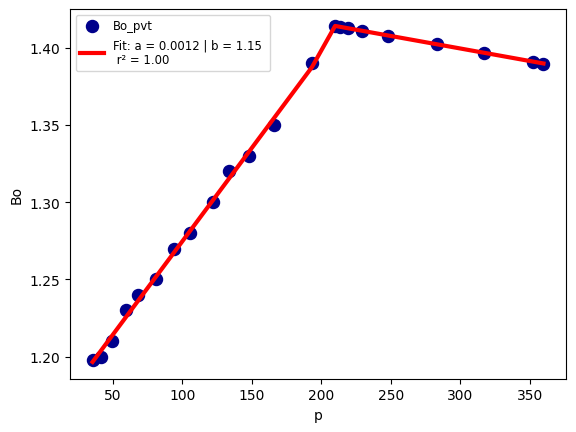

In [5]:
## Ajuste Bo

p_pvt=pvt_df["p"].values
bo_pvt=pvt_df["Bo"].values

## Escolhento intervalo de ajuste com p < pb
p_adj = p_pvt[(p_pvt<pb)]
bo_adj = bo_pvt[(p_pvt<pb)]

## Ajuste de uma reta por mínimos quadrados com p < pb
def func_bob(p, a, b):
    return a*p+b

initialGuess=[1,1]
popt, pcov = curve_fit(func_bob, p_adj, bo_adj, initialGuess)
bo_a, bo_b = popt[0], popt[1]
print(bo_a, bo_b)

## Função Bo
def func_bo(p, a, b):
    bo = np.zeros(len(p))
    for i in range(len(p)):
        if p[i] < pb:
          bo[i] = a * p[i] + b
        else:
          bo[i] = bob - co * (p[i] - pb)
    return bo

## Valores previstos
bo_prev = func_bo(p_pvt, *popt)

## Métrica de desempenho
r2 = r2_score(bo_pvt, bo_prev)

## Gráfico comparativo Bo x Bo_prev
plt.scatter(p_pvt, bo_pvt, label="Bo_pvt", color="darkblue", s=75)
# plt.scatter(p_adj, bo_adj, label="Bo_adj", color="darkorange", s=75)
plt.plot(p_pvt, bo_prev, label=f"Fit: a = {popt[0]:0.4f} | b = {popt[1]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("Bo")
plt.show()

1.5059386354307656 -1.0574564793491976


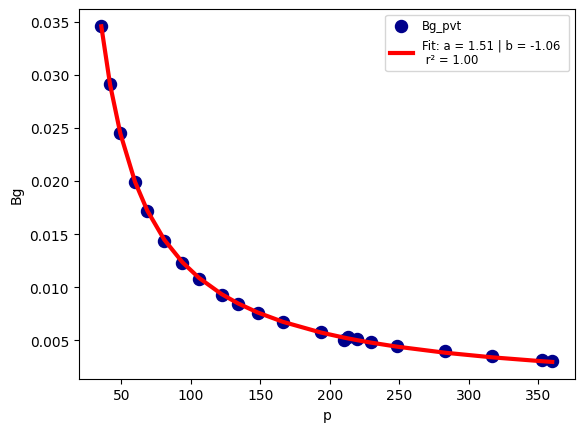

In [6]:
## Ajuste Bg

bg_pvt=pvt_df["Bg"].values

## Ajuste de uma reta por mínimos quadrados
def func_bg(p, a, b):
    return a*p**(b)

initialGuess=[1,-1]
popt, pcov = curve_fit(func_bg, p_pvt, bg_pvt, initialGuess)
bg_a, bg_b = popt[0], popt[1]
print(bg_a, bg_b)

## Valores previstos
bg_prev = func_bg(p_pvt, *popt)

## Métrica de desempenho
r2 = r2_score(bg_pvt, bg_prev)

## Gráfico comparativo Bg x Bg_prev
plt.scatter(p_pvt, bg_pvt, label="Bg_pvt", color="darkblue", s=75)
plt.plot(p_pvt, bg_prev, label=f"Fit: a = {popt[0]:0.2f} | b = {popt[1]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("Bg")
plt.show()

0.46549860654998376 15.011424226022424


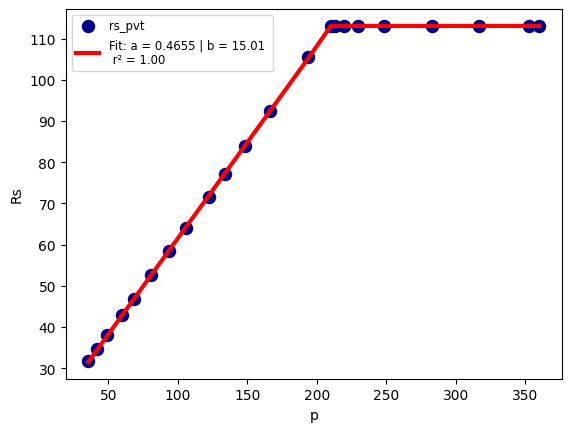

In [7]:
## Ajuste Rs

rs_pvt=pvt_df["Rs"].values

## Escolhento intervalo de ajuste com p < pb
p_adj = p_pvt[(p_pvt<pb)]
rs_adj = rs_pvt[(p_pvt<pb)]

## Ajuste de uma reta por mínimos quadrados com p < pb
def func_rsb(p, a, b):
    return a*p+b

initialGuess=[1,1]
popt, pcov = curve_fit(func_rsb, p_adj, rs_adj, initialGuess)
rs_a, rs_b = popt[0], popt[1]
print(rs_a, rs_b)

## Função rs
def func_rs(p, a, b):
    rs = np.zeros(len(p))
    for i in range(len(p)):
        if p[i] < pb:
          rs[i] = a * p[i] + b
        else:
          rs[i] = Rsi
    return rs

## Valores previstos
rs_prev = func_rs(p_pvt, *popt)

## Métrica de desempenho
r2 = r2_score(rs_pvt, rs_prev)

## Gráfico comparativo rs x rs_prev
plt.scatter(p_pvt, rs_pvt, label="rs_pvt", color="darkblue", s=75)
# plt.scatter(p_adj, rs_adj, label="rs_adj", color="darkorange", s=75)
plt.plot(p_pvt, rs_prev, label=f"Fit: a = {popt[0]:0.4f} | b = {popt[1]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("Rs")
plt.show()

-0.6694676521799026 4.524634377653334


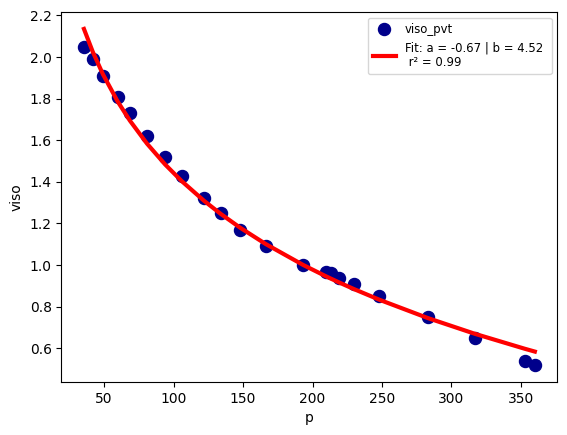

In [8]:
## Ajuste Viso

viso_pvt=pvt_df["viso"].values

## Ajuste de uma reta por mínimos quadrados
def func_viso(p, a, b):
    return a*np.log(p)+b

initialGuess=[-1,1]
popt, pcov = curve_fit(func_viso, p_pvt, viso_pvt, initialGuess)

## Valores previstos
viso_prev = func_viso(p_pvt, *popt)
viso_a, viso_b = popt[0], popt[1]
print(viso_a, viso_b)

## Métrica de desempenho
r2 = r2_score(viso_pvt, viso_prev)

## Gráfico comparativo viso x viso_prev
plt.scatter(p_pvt, viso_pvt, label="viso_pvt", color="darkblue", s=75)
plt.plot(p_pvt, viso_prev, label=f"Fit: a = {popt[0]:0.2f} | b = {popt[1]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("viso")
plt.show()

5.532705804609023e-05 0.008974925072326187


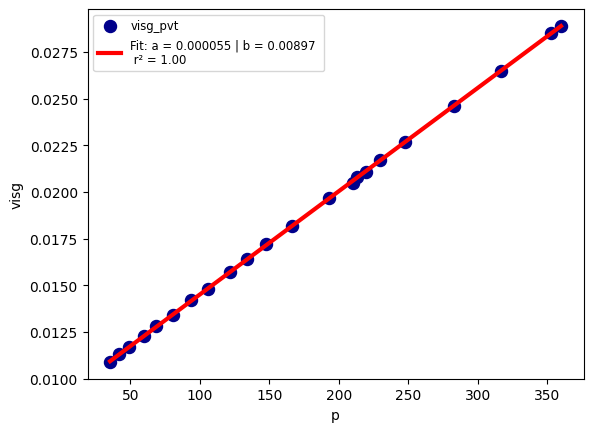

In [9]:
## Ajuste visg

visg_pvt=pvt_df["visg"].values

## Ajuste de uma reta por mínimos quadrados com p < pb
def func_visg(p, a, b):
    return a*p+b

initialGuess=[1,1]
popt, pcov = curve_fit(func_visg, p_pvt, visg_pvt, initialGuess)
visg_a, visg_b = popt[0], popt[1]
print(visg_a, visg_b)

## Valores previstos
visg_prev = func_visg(p_pvt, *popt)

## Métrica de desempenho
r2 = r2_score(visg_pvt, visg_prev)

## Gráfico comparativo visg x visg_prev
plt.scatter(p_pvt, visg_pvt, label="visg_pvt", color="darkblue", s=75)
plt.plot(p_pvt, visg_prev, label=f"Fit: a = {popt[0]:0.6f} | b = {popt[1]:0.5f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("p")
plt.ylabel("visg")
plt.show()

## Ajuste KREL

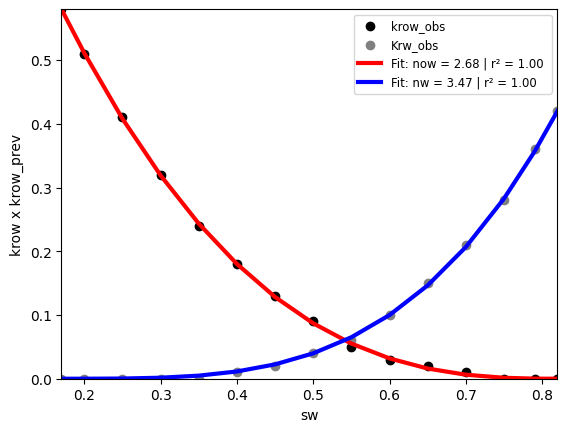

In [10]:
## Permeabilidade Relativa Óleo-Água

krow_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_krel.xlsx', sheet_name="krow")

sw = krow_df["sw"].values
krow_obs = krow_df["krow"].values
krw_obs = krow_df["krw"].values

krow_max = krow_obs[0]
krw_max = krw_obs[-1]

def f_krow(sw, now):
  return krow_max*((1-Sor-sw)/(1-Sor-Swi))**now

def f_krw(sw, nw):
  return krw_max*((sw-Swi)/(1-Sor-Swi))**nw

## Ajuste krow
initialGuess1=[2]
popt1,pcov1 = curve_fit(f_krow, sw, krow_obs, initialGuess1)
krow_pred = f_krow(sw, *popt1)
r2_1 = r2_score(krow_obs, krow_pred)
now = popt1[0]

## Ajuste krw
initialGuess2=[2]
popt2,pcov2 = curve_fit(f_krw, sw, krw_obs, initialGuess2)
krw_pred = f_krw(sw, *popt2)
r2_2 = r2_score(krw_obs, krw_pred)
nw = popt2[0]

plt.scatter(sw, krow_obs, label="krow_obs", color="black")
plt.scatter(sw, krw_obs, label="Krw_obs", color="grey")
plt.plot(sw, krow_pred, label=f"Fit: now = {now:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_1:0.2f} ", color="red", linewidth=3)
plt.plot(sw, krw_pred, label=f"Fit: nw = {nw:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:0.2f}", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("sw")
plt.ylabel("krow x krow_prev")
plt.xlim(sw[0], sw[-1])
plt.ylim(0, krow_max)
plt.show()

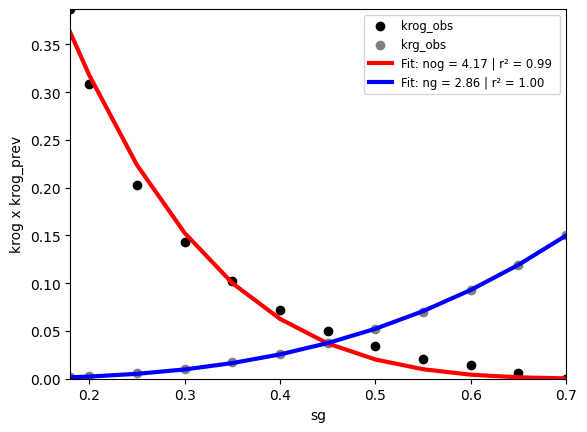

In [11]:
## Permeabilidade Relativa Gás-Óleo

krog_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_krel.xlsx', sheet_name="krog").iloc[1:,]

sg = krog_df["sg"].values
krog_obs = krog_df["krog"].values
krg_obs = krog_df["krg"].values

krog_max = krog_obs[0]
krg_max = krg_obs[-1]

def f_krog(sg, nog):
  return krog_max*((1-Sor-sg)/(1-Sor-Swi))**nog

def f_krg(sg, ng):
  return krg_max*((sg-Sgc)/(1-Sor-Swi))**ng

## Ajuste krog
initialGuess1=[3]
popt1,pcov1 = curve_fit(f_krog, sg, krog_obs, initialGuess1)
krog_pred = f_krog(sg, *popt1)
r2_1 = r2_score(krog_obs, krog_pred)
nog = popt1[0]

## Ajuste krg
initialGuess2=[3]
popt2,pcov2 = curve_fit(f_krg, sg, krg_obs, initialGuess2)
krg_pred = f_krg(sg, *popt2)
r2_2 = r2_score(krg_obs, krg_pred)
ng = popt2[0]

plt.scatter(sg, krog_obs, label="krog_obs", color="black")
plt.scatter(sg, krg_obs, label="krg_obs", color="grey")
plt.plot(sg, krog_pred, label=f"Fit: nog = {nog:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_1:0.2f} ", color="red", linewidth=3)
plt.plot(sg, krg_pred, label=f"Fit: ng = {ng:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:0.2f}", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("sg")
plt.ylabel("krog x krog_prev")
plt.xlim(sg[0], sg[-1])
plt.ylim(0, krog_max)
plt.show()

## Módulo de Ajuste de Histórico

### Importação Histórico - Campo

In [12]:
hist_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_hist-m.xlsx').iloc[1:,:]
# hist_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_hist-m.xlsx').iloc[1:49,:]
hist_df.head()

,Date,Press,Np,Gp,Wp,Winj
1,2013-06-30,332,0,0,0,0
2,2013-07-31,331,61938,6858068,0,0
3,2013-08-31,329,124403,13532213,0,0
4,2013-09-30,328,182423,20112443,0,0
5,2013-10-31,327,244857,26856741,0,0


In [13]:
hist_df["t"] = (hist_df["Date"]-hist_df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
hist_df["dt"]=hist_df["t"].diff().fillna(0)
hist_df["qo"]=(hist_df["Np"].diff()/hist_df["dt"]).fillna(0)
hist_df["qg"]=(hist_df["Gp"].diff()/hist_df["dt"]).fillna(0)
hist_df["qw"]=(hist_df["Wp"].diff()/hist_df["dt"]).fillna(0)
hist_df["qwi"]=(hist_df["Winj"].diff()/hist_df["dt"]).fillna(0)
# hist_df["p_med"]= (hist_df["Press"]+(hist_df["Press"]-hist_df["Press"].diff()).fillna(hist_df["Press"].iloc[0]))/2
# hist_df["dp"]= hist_df["Press"].iloc[0]-hist_df["Press"]
# hist_df["pmt"]=((hist_df["Press"].iloc[0]-hist_df["p_med"])*hist_df["dt"]).cumsum()
hist_df.tail()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi
128,2024-01-31,305,24757936,2793256452,4393983,36864922,3867.0,31.0,9053.0,986609.0,6446.0,19374.0
129,2024-02-29,306,25022300,2822363056,4583991,37475894,3896.0,29.0,9116.0,1003676.0,6552.0,21068.0
130,2024-03-31,307,25304090,2853787229,4789676,38123794,3927.0,31.0,9090.0,1013683.0,6635.0,20900.0
131,2024-04-30,308,25567400,2883725639,4991816,38702374,3957.0,30.0,8777.0,997947.0,6738.0,19286.0
132,2024-05-31,309,25832419,2913898931,5206739,39341191,3988.0,31.0,8549.0,973332.0,6933.0,20607.0


In [14]:
# EBM
# F/(Eo+mEg+(1+m)Efw)=N+We/(Eo+mEg+(1+m)Efw)
# We = F-N*(Eo+mEg+(1+m)Efw)

# Bt=Bo+(Rsi-Rs)*Bg
# F = Np*(Bt+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rsi-Rs)*Bg+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rp-Rs)*Bg)+(Wp-Winj)*Bw

# Eo= Bt-Bti

# Eg= Boi*(Bg/Bgi-1)

# Efw = Boi*((cf+cw.Swi)/(1-Swi))*∆p
# Efw = Boi*((cf+cw.Swi)/(1-Swi))*(pi-p)

p = hist_df["Press"].values

bo = func_bo(p, bo_a, bo_b)
hist_df["Bo"]=bo

bg = func_bg(p, bg_a, bg_b)
hist_df["Bg"]=bg

rs = func_rs(p, rs_a, rs_b)
hist_df["Rs"]=rs

uo = func_viso(p, viso_a, viso_b)
hist_df["Viso"]=uo

ug = func_visg(p, visg_a, visg_b)
hist_df["Visg"]=ug

hist_df["Rp"] = (hist_df["Gp"]/hist_df["Np"]).fillna(0)

# hist_df["Bt"]=hist_df["Bo"]+(Rsi-hist_df["Rs"])*hist_df["Bg"]
# hist_df["F"] = hist_df["Np"]*(hist_df["Bt"]+(hist_df["Rp"]-Rsi)*hist_df["Bg"])+(hist_df["Wp"]-hist_df["Winj"])*Bw
hist_df["F"] = hist_df["Np"]*(hist_df["Bo"]+(hist_df["Rp"]-hist_df["Rs"])*hist_df["Bg"])+(hist_df["Wp"]-hist_df["Winj"])*Bw
# hist_df["Eo"] = hist_df["Bt"]-hist_df["Bt"].iloc[0]
hist_df["Eo"] = hist_df["Bo"]-hist_df["Bo"].iloc[0]+(hist_df["Rs"].iloc[0]-hist_df["Rs"])*hist_df["Bg"]
# hist_df["Eg"] = hist_df["Bt"].iloc[0]*(hist_df["Bg"]/hist_df["Bg"].iloc[0]-1)
hist_df["Eg"] = hist_df["Bo"].iloc[0]*((hist_df["Bg"]/hist_df["Bg"].iloc[0])-1)
# hist_df["Efw"] = hist_df["Bt"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(hist_df["Press"].iloc[0]-hist_df["Press"])
hist_df["Efw"] = (1+m)*hist_df["Bo"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(hist_df["Press"].iloc[0]-hist_df["Press"])

hist_df.head()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,Bo,Bg,Rs,Viso,Visg,Rp,F,Eo,Eg,Efw
1,2013-06-30,332,0,0,0,0,0.0,0.0,0.0,0.0,...,1.394241,0.003249,113.06,0.638284,0.027344,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331,61938,6858068,0,0,31.0,31.0,1998.0,221228.0,...,1.394403,0.003260,113.06,0.640304,0.027288,110.724725,85895.010882,0.000162,0.004455,0.000103
3,2013-08-31,329,124403,13532213,0,0,62.0,31.0,2015.0,215295.0,...,1.394727,0.003281,113.06,0.644361,0.027178,108.777224,171760.217854,0.000486,0.013447,0.000308
4,2013-09-30,328,182423,20112443,0,0,92.0,30.0,1934.0,219341.0,...,1.394889,0.003291,113.06,0.646399,0.027122,110.251684,252773.623635,0.000648,0.017986,0.000410
5,2013-10-31,327,244857,26856741,0,0,123.0,31.0,2014.0,217558.0,...,1.395051,0.003302,113.06,0.648443,0.027067,109.683370,338857.869258,0.000810,0.022553,0.000513


### Ajuste de Histórico

In [15]:
# train = hist_df.copy()
# train = train.drop(["Gp", "Bt", "Bo", "Bg", "Rs", "F", "Eo", "Eg", "Efw", "p", "dt", "dp"], axis=1)

p=hist_df["Press"].values
# p_med=hist_df["p_med"].values
t=hist_df["t"].values
dt=hist_df["dt"].values
F=hist_df["F"].values
Eo=hist_df["Eo"].values
Eg=hist_df["Eg"].values
Efw=hist_df["Efw"].values
npp=hist_df["Np"].values
gp=hist_df["Gp"].values
rp=hist_df["Rp"].values
wp=hist_df["Wp"].values
winj=hist_df["Winj"].values
qo=hist_df["qo"].values
qg=hist_df["qg"].values
qw=hist_df["qw"].values
qwi=hist_df["qwi"].values

Estimativa de N: 183.81
Estimativa de Wi: 100.00
Estimativas de J: 100.00
desvio (MMm³): 0.2055
r²: 0.75


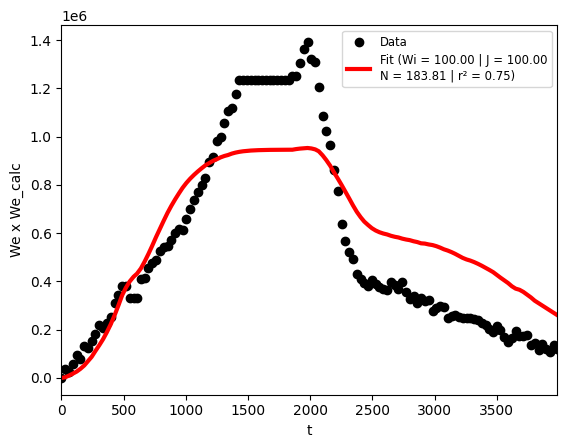

In [16]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We

## Fetkovich
## ∆Wen = (Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## Wen = Wen-1+(Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## pan-1 = pi.[1-Wen-1/Wei]
## pn = [pn-1+pn]/2
## ∆t = t_j+1-t_j
## n = 1....n

##Aquífero Fetkovich

# Função objetivo
def objective(x, Eo, Eg, Efw, F, m):
    N = x[0]  # N é constante
    Wi = x[1]  # Wei é constante
    J = x[2]  # J é constante
    Wei = (cf+cw)*Wi*p[0]*10**6
    Wen = np.zeros(len(t))
    pa_med = np.zeros(len(t))
    pa_med[0] = p[0]
    for i in range(1,len(t)):
      pa_med[i-1]=p[0]*(1-(Wen[i-1]/Wei))
      Wen[i]=Wen[i-1]+(Wei/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J*p[0]*dt[i]/Wei))
    We_EBM = F - (N*10**6) * (Eo + m * Eg + Efw)
    return np.mean(((We_EBM - Wen)/10**6) ** 2)**0.5
    # return np.sum((We_EBM - Wen) ** 2)

# Chute inicial para N, Wi e J
x0 = np.array([130] + [100] + [10])

# Limites para N, Wi e J
bounds = [(10, 300)] + [(100, 1000)] + [(1, 100)]

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m), bounds=bounds)

N_est = result.x[0]
Wi_est = result.x[1]
J_est = result.x[2]

print(f"Estimativa de N: {N_est:0.2f}")
print(f"Estimativa de Wi: {Wi_est:0.2f}")
print(f"Estimativas de J: {J_est:0.2f}")

Wei_est = (cf+cw)*Wi_est*p[0]*10**6
# print(Wei_est)
Wen = np.zeros(len(t))
pa_med = np.zeros(len(t))
pa_med[0] = p[0]
for i in range(1,len(t)):
  pa_med[i-1] = p[0]*(1-(Wen[i-1]/Wei_est))
  Wen[i] = Wen[i-1]+(Wei_est/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J_est*p[0]*dt[i]/Wei_est))
pa_med[len(t)-1] = p[0]*(1-(Wen[len(t)-1]/Wei_est))
We_EBM = F - (N_est*10**6) * (Eo + m * Eg + Efw)
print(f"desvio (MMm³): {np.mean(((We_EBM - Wen)/10**6) ** 2)**0.5:0.4f}")

r2_2 = r2_score(We_EBM, Wen)
print(f"r²: {r2_2:0.2f}")

plt.scatter(t, We_EBM, label="Data", color="black")
plt.plot(t, Wen, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("We x We_calc")
plt.xlim(0, hist_df.iloc[-1, 6])
plt.show()

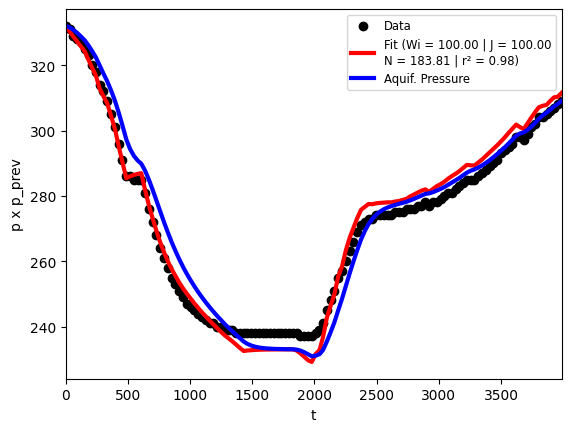

In [17]:
## Previsao de pressao

p_prev=np.zeros(len(t))
we_aquif=np.zeros(len(t))
ppa_med=np.zeros(len(t))
we_ebm=np.zeros(len(t))

for i in range(len(t)):
  if i == 0:
    p_prev[i]=p[0]
    we_aquif[i]=0
    ppa_med[i]=p[0]
    we_ebm[i]=0
  else:
    # Função objetivo
    def obj_f(x, m, N, Wei, J):
      pn = x[0]  # pressao prevista

      ## Aquifero
      ppa_med[i-1]=p[0]*(1-(we_aquif[i-1]/Wei))
      we_aquif[i]=we_aquif[i-1]+(Wei/p[0])*(ppa_med[i-1]-pn)*(1-np.exp(-J*p[0]*dt[i]/Wei))

      ## EBM
      if pn < pb:
        bop = bo_a * pn + bo_b
        rsp = rs_a * pn + rs_b
      else:
        bop = bob - co * (pn - pb)
        rsp = Rsi
      bgp = bg_a*pn**(bg_b)
      fp=npp[i]*(bop+(rp[i]-rsp)*bgp)+(wp[i]-winj[i])*Bw
      eop=bop-bo[0]+(Rsi-rsp)*bgp
      egp=bo[0]*((bgp/bg[0])-1)
      efwp=(1+m)*bo[0]*((cf+cw*Swi)/(1-Swi))*(p[0]-pn)
      we_ebm[i]=fp-N*(eop+m*egp+efwp)*10**6

      return (we_ebm[i] - we_aquif[i]) ** 2

    x0 = [p_prev[i-1]]
    result = minimize(obj_f, x0, args=(m, N_est, Wei_est, J_est))
    p_prev[i]=result.x[0]

  ppa_med[i]=p[0]*(1-(we_aquif[i]/Wei_est))

r2_2 = r2_score(p, p_prev)
# print(p_prev)

plt.scatter(t, p, label="Data", color="black")
plt.plot(t, p_prev, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.plot(t, ppa_med, label="Aquif. Pressure", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p x p_prev")
plt.xlim(0, hist_df.iloc[-1, 6])
plt.show()

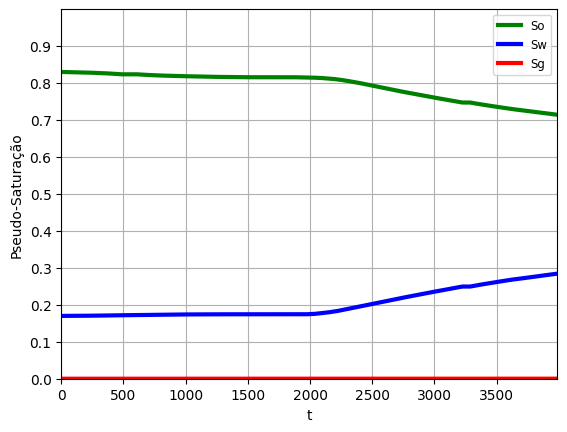

In [18]:
## Saturacoes de fluidos

So = np.zeros(len(t))
Sw = np.zeros(len(t))
Sg = np.zeros(len(t))
cct = np.zeros(len(t))
Vpp = np.zeros(len(t))
Vp = (N_est*10**6) * bo[0] / (1 - Swi)
G = ((N_est*10**6) * Rsi + m * (N_est*10**6) * bo[0] / bg[0])
# print(G)

for i in range(len(t)):
  cct[i] = (1 + (Swi * cw / (1 - Swi) + cf) * (p[i] - p[0]))
  Vpp[i] = Vp * (1 + cf * (p[i] - p[0]))
  So[i] = ((N_est*10**6) - npp[i]) *bo[0] / Vpp[i]
  Sw[i] = (Swi * Vp * (1 - cw * (p[i] - p[0])) + ((winj[i] - wp[i] + Wen[i]) * Bw)) / Vpp[i]
  Sg[i] = bg[i] * (G - gp[i] - ((N_est*10**6) - npp[i]) * rs[i] - cct[i] * m * (N_est*10**6) * bo[0] / bg[0]) / Vpp[i]

# print(Sg)
fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 1., 0.1))
plt.grid()
plt.plot(t, So, label="So", color="green", linewidth=3)
plt.plot(t, Sw, label="Sw", color="blue", linewidth=3)
plt.plot(t, Sg, label="Sg", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("Pseudo-Saturação")
plt.ylim(0.0, 1.0)
plt.xlim(0, hist_df.iloc[-1, 6])
plt.show()

### Importação Histórico - Poço

In [19]:
## Importação do histórico por poço
wells_hist_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_hist_well-m.xlsx')
wells_hist_df.head()

,well,Date,BHP,Np,Gp,Wp,Winj
0,NA1A,2013-06-30,324,0,0,0,0
1,NA1A,2013-07-31,256,61938,6858068,0,0
2,NA1A,2013-08-31,262,124403,13532213,0,0
3,NA1A,2013-09-30,248,182423,20112443,0,0
4,NA1A,2013-10-31,249,244857,26856741,0,0


In [20]:
wells = wells_hist_df["well"].drop_duplicates().values.astype(str)
wells_prod = wells[~np.char.startswith(wells, 'INJ')]
wells_inj = wells[np.char.startswith(wells, 'INJ')]

wells_prod, wells_inj

(array(['NA1A', 'NA2', 'NA3D', 'RJS19', 'PROD005', 'PROD008', 'PROD009',
        'PROD010', 'PROD012', 'PROD014', 'PROD021', 'PROD023A', 'PROD024A',
        'PROD025A'], dtype='<U8'),
 array(['INJ003', 'INJ005', 'INJ006', 'INJ007', 'INJ010', 'INJ015',
        'INJ017', 'INJ019', 'INJ021', 'INJ022', 'INJ023'], dtype='<U8'))

In [21]:
len(wells_prod), len(wells_inj)

(14, 11)

In [22]:
wells_prod_hist_df = []

for i in range(len(wells_prod)):
  wells_prod_hist_df.append(wells_hist_df[wells_hist_df['well'] == wells_prod[i]].copy())
  wells_prod_hist_df[i]["t"]=(wells_prod_hist_df[i]["Date"]-wells_prod_hist_df[i]["Date"].iloc[0]).astype("int64")/10**9/60/60/24
  wells_prod_hist_df[i]["dt"]=wells_prod_hist_df[i]["t"].diff().fillna(0)
  wells_prod_hist_df[i]["qo"]=(wells_prod_hist_df[i]["Np"].diff()/wells_prod_hist_df[i]["dt"]).fillna(0)
  wells_prod_hist_df[i]["qg"]=(wells_prod_hist_df[i]["Gp"].diff()/wells_prod_hist_df[i]["dt"]).fillna(0)
  wells_prod_hist_df[i]["qw"]=(wells_prod_hist_df[i]["Wp"].diff()/wells_prod_hist_df[i]["dt"]).fillna(0)
  wells_prod_hist_df[i]["qwi"]=(wells_prod_hist_df[i]["Winj"].diff()/wells_prod_hist_df[i]["dt"]).fillna(0)
  # wells_prod_hist_df[i]["qb"]=wells_prod_hist_df[i]["qo"]+wells_prod_hist_df[i]["qw"]
  wells_prod_hist_df[i]["RAO"]=(wells_prod_hist_df[i]["qw"]/wells_prod_hist_df[i]["qo"]).fillna(1E-6)
  # wells_prod_hist_df[i]["RGO"]=(wells_prod_hist_df[i]["qg"]/wells_prod_hist_df[i]["qo"]).fillna(0)

wells_prod_hist_df[0]

,well,Date,BHP,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi,RAO
0,NA1A,2013-06-30,324,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001
1,NA1A,2013-07-31,256,61938,6858068,0,0,31.0,31.0,1998.0,221228.0,0.0,0.0,0.000000
2,NA1A,2013-08-31,262,124403,13532213,0,0,62.0,31.0,2015.0,215295.0,0.0,0.0,0.000000
3,NA1A,2013-09-30,248,182423,20112443,0,0,92.0,30.0,1934.0,219341.0,0.0,0.0,0.000000
4,NA1A,2013-10-31,249,244857,26856741,0,0,123.0,31.0,2014.0,217558.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,NA1A,2024-01-31,223,4352533,491925193,330103,0,3867.0,31.0,1488.0,161964.0,494.0,0.0,0.331989
128,NA1A,2024-02-29,229,4396062,496554028,346517,0,3896.0,29.0,1501.0,159615.0,566.0,0.0,0.377082
129,NA1A,2024-03-31,237,4442283,501390152,364125,0,3927.0,31.0,1491.0,156004.0,568.0,0.0,0.380952
130,NA1A,2024-04-30,230,4482903,506082482,381495,0,3957.0,30.0,1354.0,156411.0,579.0,0.0,0.427622


In [23]:
wells_inj_hist_df = []

for i in range(len(wells_inj)):
  wells_inj_hist_df.append(wells_hist_df[wells_hist_df['well'] == wells_inj[i]].copy())
  wells_inj_hist_df[i]["t"]=(wells_inj_hist_df[i]["Date"]-wells_inj_hist_df[i]["Date"].iloc[0]).astype("int64")/10**9/60/60/24
  wells_inj_hist_df[i]["dt"]=wells_inj_hist_df[i]["t"].diff().fillna(0)
  wells_inj_hist_df[i]["qo"]=(wells_inj_hist_df[i]["Np"].diff()/wells_inj_hist_df[i]["dt"]).fillna(0)
  wells_inj_hist_df[i]["qg"]=(wells_inj_hist_df[i]["Gp"].diff()/wells_inj_hist_df[i]["dt"]).fillna(0)
  wells_inj_hist_df[i]["qw"]=(wells_inj_hist_df[i]["Wp"].diff()/wells_inj_hist_df[i]["dt"]).fillna(0)
  wells_inj_hist_df[i]["qwi"]=(wells_inj_hist_df[i]["Winj"].diff()/wells_inj_hist_df[i]["dt"]).fillna(0)

wells_inj_hist_df[0]

,well,Date,BHP,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi
1848,INJ003,2013-06-30,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1849,INJ003,2013-07-31,0,0,0,0,0,31.0,31.0,0.0,0.0,0.0,0.0
1850,INJ003,2013-08-31,0,0,0,0,0,62.0,31.0,0.0,0.0,0.0,0.0
1851,INJ003,2013-09-30,0,0,0,0,0,92.0,30.0,0.0,0.0,0.0,0.0
1852,INJ003,2013-10-31,0,0,0,0,0,123.0,31.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,INJ003,2024-01-31,347,0,0,0,5615925,3867.0,31.0,0.0,0.0,0.0,2697.0
1976,INJ003,2024-02-29,352,0,0,0,5691325,3896.0,29.0,0.0,0.0,0.0,2600.0
1977,INJ003,2024-03-31,349,0,0,0,5766996,3927.0,31.0,0.0,0.0,0.0,2441.0
1978,INJ003,2024-04-30,347,0,0,0,5846406,3957.0,30.0,0.0,0.0,0.0,2647.0


### Ajuste logRAOxNp

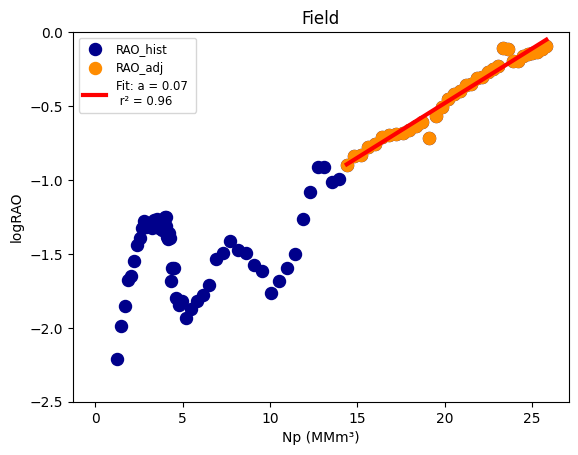

In [24]:
## Ajuste LogRAOxNp - Campo

RAO = np.zeros(len(t))
for i in range(len(t)):
  if qo[i] == 0 or qw[i] == 0:
    RAO[i]=1E-6
  else:
    RAO[i]=qw[i]/qo[i]

## Escolhendo intervalo e retirando outliers para o ajuste
RAO_adj = RAO[(npp>1.4E7) & (np.log10(RAO)>-6)]
npp_adj = npp[(npp>1.4E7) & (np.log10(RAO)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(npp_adj, np.log10(RAO_adj), 1)
a = coeficientes[0]
b = coeficientes[1]

# Valores previstos
logRAO_prev = a*npp_adj + b

# Métrica de desempenho
r2 = r2_score(np.log10(RAO_adj), logRAO_prev)

plt.scatter(npp/10**6, np.log10(RAO), label="RAO_hist", color="darkblue", s=75)
plt.scatter(npp_adj/10**6, np.log10(RAO_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(npp_adj/10**6, logRAO_prev, label=f"Fit: a = {a*10**6:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title("Field")
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, 0)
plt.show()

In [25]:
hist_df["P_prev"]=p_prev
hist_df["So"]=So
hist_df["Sw"]=Sw
hist_df["Sg" ]=Sg
hist_df["We_ebm"]=We_EBM
hist_df["We_aqui"]=Wen
hist_df["Pa_med"]=ppa_med
hist_df["cct"]=cct
hist_df["Vpp"]=Vpp
hist_df["RAO"]=RAO

hist_df.head()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,P_prev,So,Sw,Sg,We_ebm,We_aqui,Pa_med,cct,Vpp,RAO
1,2013-06-30,332,0,0,0,0,0.0,0.0,0.0,0.0,...,332.000000,0.830000,0.170000,0.000000,0.000000,0.000000,332.000000,1.000000,3.087635e+08,0.000001
2,2013-07-31,331,61938,6858068,0,0,31.0,31.0,1998.0,221228.0,...,330.325778,0.829764,0.170026,0.000002,37255.016426,2667.868888,331.556003,0.999937,3.087471e+08,0.000001
3,2013-08-31,329,124403,13532213,0,0,62.0,31.0,2015.0,215295.0,...,328.716249,0.829570,0.170084,0.000006,25840.234485,9963.968155,330.802913,0.999812,3.087144e+08,0.000001
4,2013-09-30,328,182423,20112443,0,0,92.0,30.0,1934.0,219341.0,...,327.240379,0.829352,0.170127,0.000005,58213.645810,17770.796559,329.884295,0.999749,3.086980e+08,0.000001
5,2013-10-31,327,244857,26856741,0,0,123.0,31.0,2014.0,217558.0,...,325.699633,0.829114,0.170173,0.000009,95657.896977,26397.401907,328.774541,0.999686,3.086816e+08,0.000001


In [26]:
## Inicialização dos parâmetros dos poços

aw = np.zeros(len(wells_prod))
bw = np.zeros(len(wells_prod))
BHPP = np.zeros(len(wells_prod))
BHPI = np.zeros(len(wells_inj))
IP = np.zeros(len(wells_prod))
II = np.zeros(len(wells_inj))

0.4875870040077862


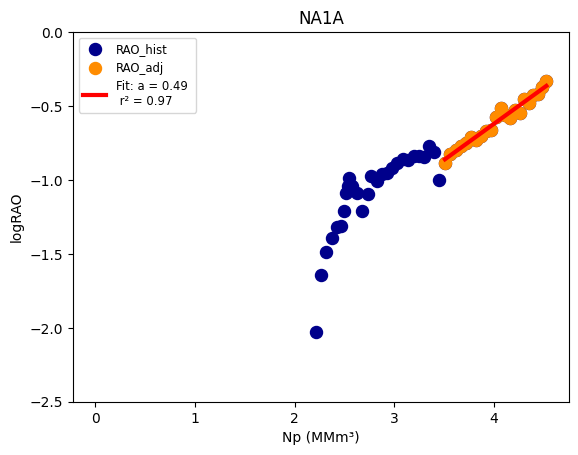

In [27]:
## Ajuste LogRAOxNp - Well 0

w_num = 0

qow = wells_prod_hist_df[0]["qo"].values
qww = wells_prod_hist_df[0]["qw"].values
nppw = wells_prod_hist_df[0]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 3.5
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, 0)
plt.show()

1.4702945444976583


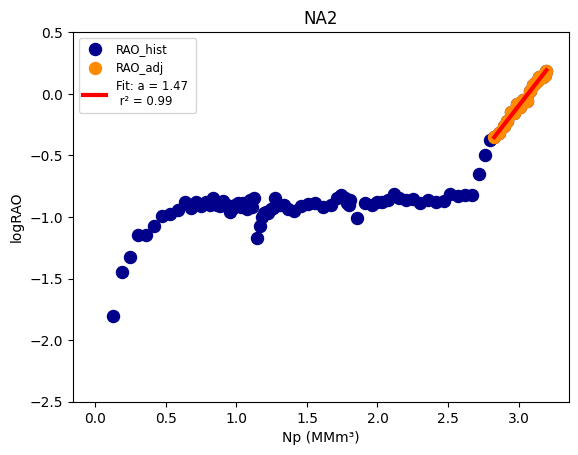

In [28]:
## Ajuste LogRAOxNp - Well 1

w_num = 1

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 2.8
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

0.8395962379108004


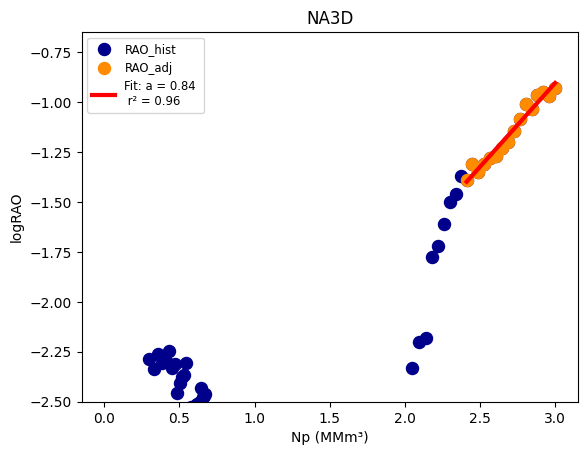

In [29]:
## Ajuste LogRAOxNp - Well 2

w_num = 2

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 2.4
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.0737554062527874


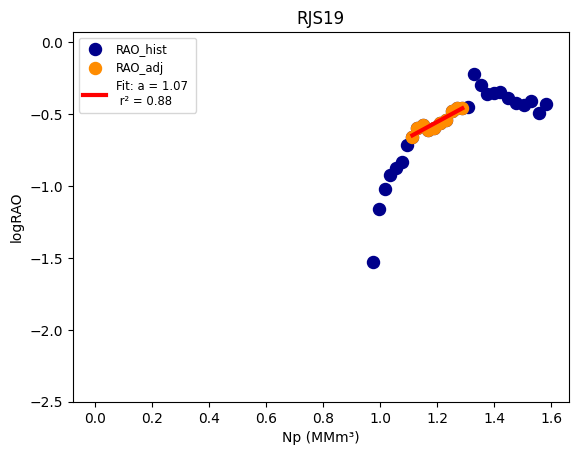

In [30]:
## Ajuste LogRAOxNp - Well 3

w_num = 3

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.1
npp_max = 1.3
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# # Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# # Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.0300059658867033


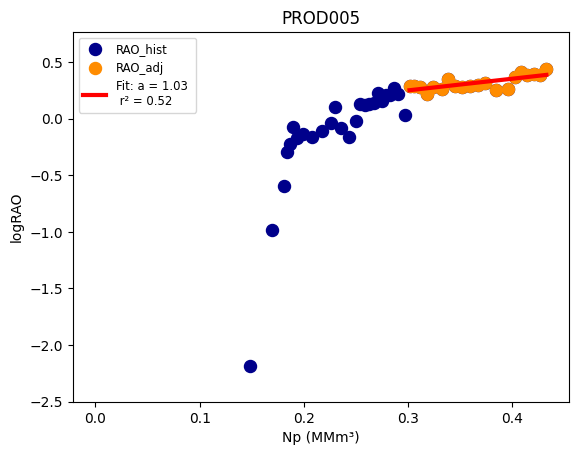

In [31]:
## Ajuste LogRAOxNp - Well 4

w_num = 4

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.3
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.2954635228358717


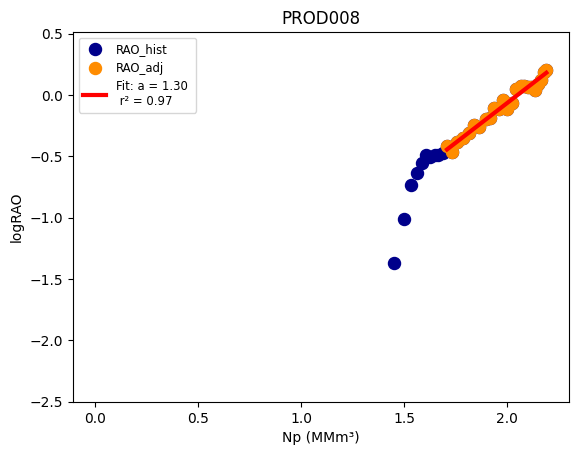

In [32]:
## Ajuste LogRAOxNp - Well 5

w_num = 5

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.7
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

0.10686653688294459


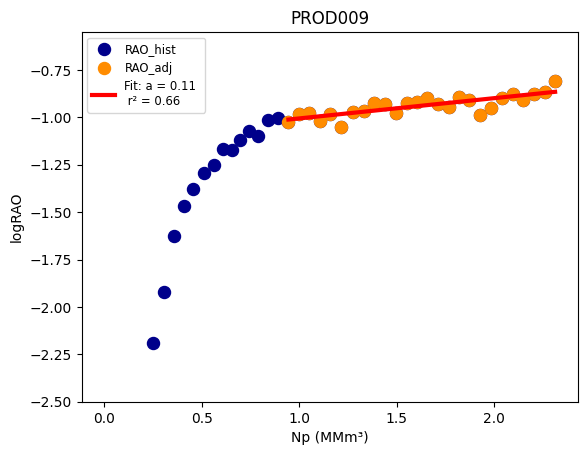

In [33]:
## Ajuste LogRAOxNp - Well 6

w_num = 6

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.9
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

5.916694896694904


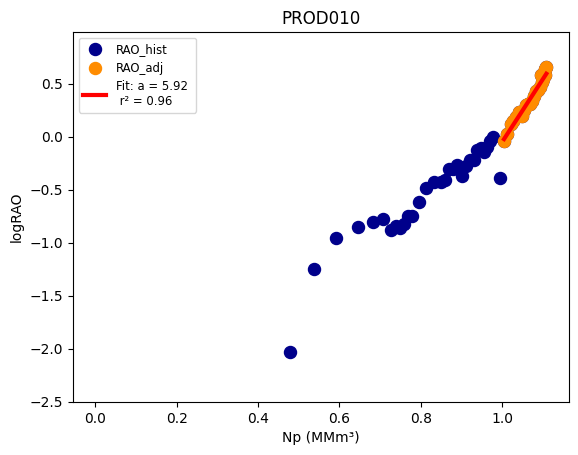

In [34]:
## Ajuste LogRAOxNp - Well 7

w_num = 7

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.0
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

3.08479205973161


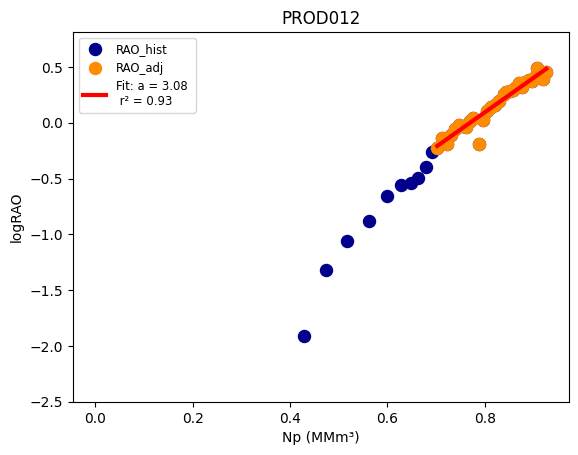

In [35]:
## Ajuste LogRAOxNp - Well 8

w_num = 8

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.7
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.6716552194326306


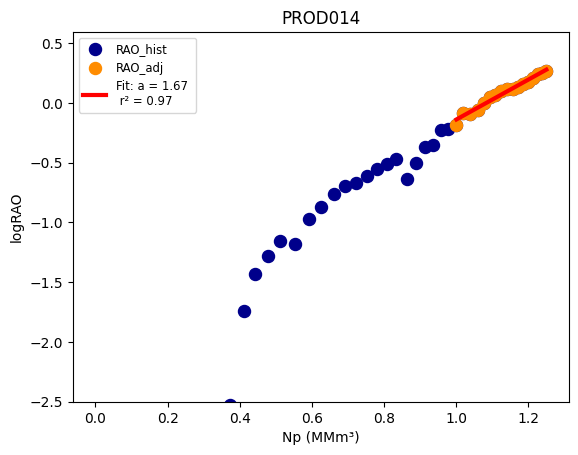

In [36]:
## Ajuste LogRAOxNp - Well 9

w_num = 9

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.0
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.017887179733196


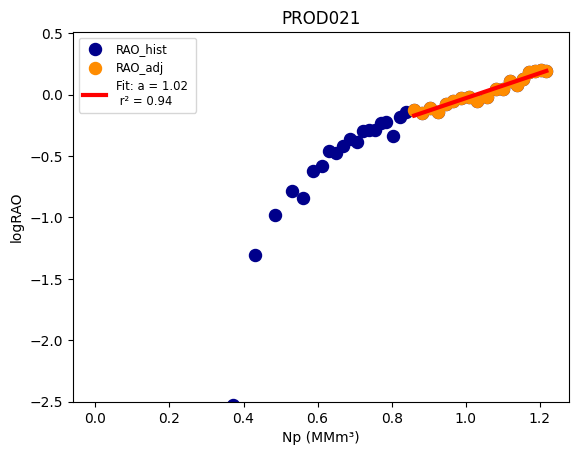

In [37]:
## Ajuste LogRAOxNp - Well 10

w_num = 10

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.85
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.281812094363807


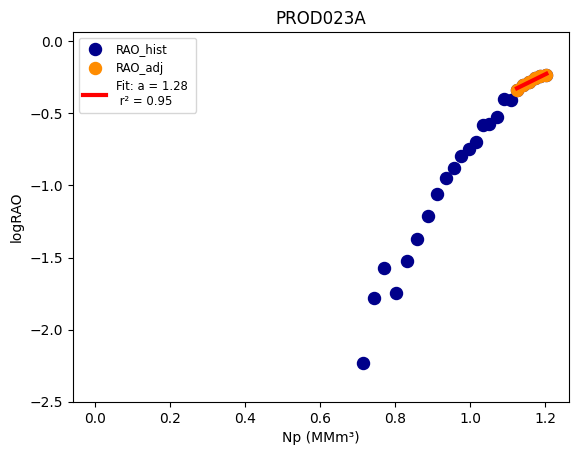

In [38]:
## Ajuste LogRAOxNp - Well 11

w_num = 11

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.11
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

3.3219637238838144


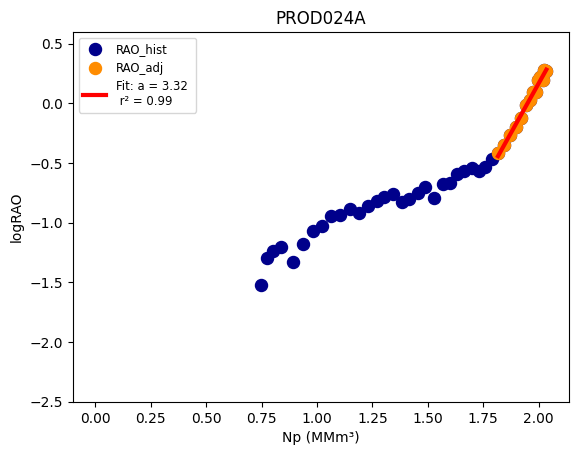

In [39]:
## Ajuste LogRAOxNp - Well 12

w_num = 12

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 1.8
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

1.2751630559127751


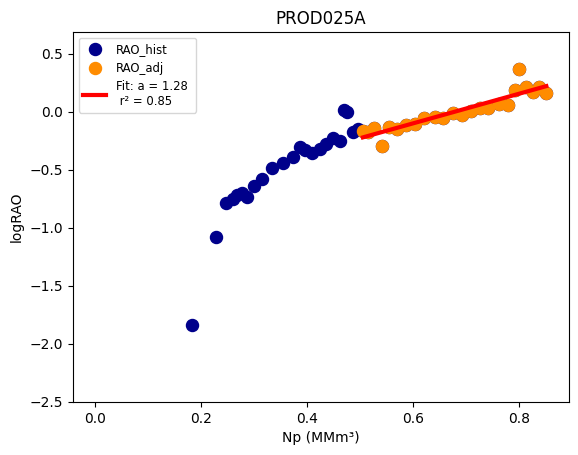

In [40]:
## Ajuste LogRAOxNp - Well 13

w_num = 13

qow = wells_prod_hist_df[w_num]["qo"].values
qww = wells_prod_hist_df[w_num]["qw"].values
nppw = wells_prod_hist_df[w_num]["Np"].values/10**6

RAOw = np.zeros(len(t))
for i in range(len(t)):
  if qow[i] == 0 or qww[i] == 0:
    RAOw[i]=1E-6
  else:
    RAOw[i]=qww[i]/qow[i]

# Escolhendo intervalo e retirando outliers para o ajuste
npp_min = 0.5
npp_max = 9999
RAOw_adj = RAOw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]
nppw_adj = nppw[(nppw>npp_min) & (nppw<npp_max) & (np.log10(RAOw)>-6)]

# Ajuste de uma reta por mínimos quadrados
coeficientes = np.polyfit(nppw_adj, np.log10(RAOw_adj), 1)
aw[w_num] = coeficientes[0]
bw[w_num] = coeficientes[1]

print(aw[w_num])

# Valores previstos
logRAOw_prev = aw[w_num]*nppw_adj + bw[w_num]

# Métrica de desempenho
r2 = r2_score(np.log10(RAOw_adj), logRAOw_prev)

plt.scatter(nppw, np.log10(RAOw), label="RAO_hist", color="darkblue", s=75)
plt.scatter(nppw_adj, np.log10(RAOw_adj), label="RAO_adj", color="darkorange", s=75)
plt.plot(nppw_adj, logRAOw_prev, label=f"Fit: a = {aw[w_num]:0.2f} \n r\N{SUPERSCRIPT TWO} = {r2:0.2f}", color="red", linewidth=3)
plt.title(wells_prod[w_num])
plt.legend(fontsize='small')
plt.xlabel("Np (MMm³)")
plt.ylabel("logRAO")
plt.ylim(-2.5, None)
plt.show()

In [41]:
aw

array([0.487587  , 1.47029454, 0.83959624, 1.07375541, 1.03000597,
       1.29546352, 0.10686654, 5.9166949 , 3.08479206, 1.67165522,
       1.01788718, 1.28181209, 3.32196372, 1.27516306])

## Módulo Previsão

### Ajuste Ponto de Partida

In [42]:
# Definição de BHP e IP

for w in range(len(wells_prod)):
  BHPP[w] = wells_prod_hist_df[w]["BHP"].values[-1]
  IP[w] = (wells_prod_hist_df[w]["qo"].values[-1]+wells_prod_hist_df[w]["qw"].values[-1])/(p_prev[-1]-BHPP[0])

BHPP, IP

(array([228., 267., 190., 195., 258., 289., 239., 300., 314., 217., 292.,
        185., 246., 314.]),
 array([24.50033039, 12.11844299, 16.83649292, 13.69910946,  8.33442324,
        12.15436722, 23.75789613,  4.86174689,  8.7655141 , 13.27999335,
        15.56716984,  9.6516453 ,  9.48399886, 12.3818874 ]))

In [43]:
# Definição de BHP e II

for w in range(len(wells_inj)):
  BHPI[w] = wells_inj_hist_df[w]["BHP"].values[-1]
  II[w] = wells_inj_hist_df[w]["qwi"].values[-1]/(BHPI[0]-p_prev[-1])

BHPI, II

(array([351., 351., 347., 351., 352., 352., 340., 352., 352., 350., 350.]),
 array([ 68.52207697,  29.57641755,  19.24492923,  46.46637518,
         45.9346074 ,  24.8158298 , 117.77390243,  34.38764986,
        101.39039031,  17.57365906,  16.10496709]))

In [44]:
verif=p_prev[-1]-BHPP
verif

array([ 83.50907795,  44.50907795, 121.50907795, 116.50907795,
        53.50907795,  22.50907795,  72.50907795,  11.50907795,
        -2.49092205,  94.50907795,  19.50907795, 126.50907795,
        65.50907795,  -2.49092205])

In [45]:
## Ajustando BHP dos poços num 8 e 13 para evitar DD negativo
## Assumingo DD de 50 kgf/cm²

BHPP[8] = p_prev[-1]-50
IP[8] = (wells_prod_hist_df[8]["qo"].values[-1]+wells_prod_hist_df[8]["qw"].values[-1])/(p_prev[-1]-BHPP[8])

BHPP[13] = p_prev[-1]-50
IP[13] = (wells_prod_hist_df[13]["qo"].values[-1]+wells_prod_hist_df[13]["qw"].values[-1])/(p_prev[-1]-BHPP[13])

IP[8], IP[13]

(14.64, 20.68)

In [46]:
## Ajuste de IP para corrigir ponto de partida da bruta

# Produtores
IP[0] = 23.0
IP[1] = 20.0
IP[2] = 12.0
IP[3] = 10.0
IP[4] = 12.0
IP[5] = 40.0
IP[6] = 27.0
IP[7] = 25.0
# IP[8] =
IP[9] = 12.0
IP[10] = 60.0
IP[11] = 6.0
IP[12] = 12.0
# IP[13] =

# Injetores
# II[0] =
# II[1] =
# II[2] =
# II[3] =
# II[4] =
# II[5] =
II[6] = 170.0
# II[7] =
II[8] = 100.0
II[9] = 20.0
II[10] = 18.5

In [47]:
BHPP, IP

(array([228.        , 267.        , 190.        , 195.        ,
        258.        , 289.        , 239.        , 300.        ,
        261.50907795, 217.        , 292.        , 185.        ,
        246.        , 261.50907795]),
 array([23.  , 20.  , 12.  , 10.  , 12.  , 40.  , 27.  , 25.  , 14.64,
        12.  , 60.  ,  6.  , 12.  , 20.68]))

In [48]:
verif=p_prev[-1]-BHPP
verif

array([ 83.50907795,  44.50907795, 121.50907795, 116.50907795,
        53.50907795,  22.50907795,  72.50907795,  11.50907795,
        50.        ,  94.50907795,  19.50907795, 126.50907795,
        65.50907795,  50.        ])

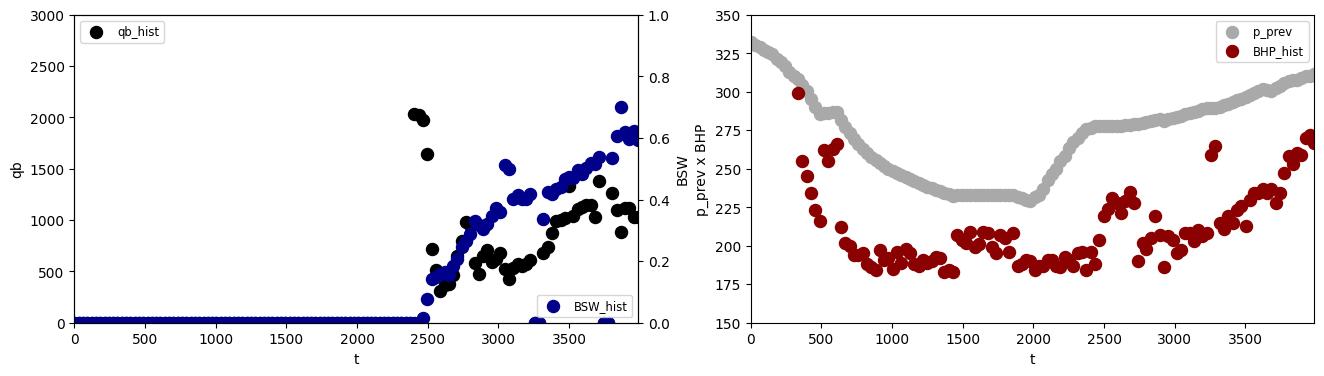

In [50]:
## Gráfico de Qb, BSW e BHP - Poço

w_num = 1

BHPPw = wells_prod_hist_df[w_num]["BHP"].values

qbw_hist = np.zeros(len(t))
BSWw = np.zeros(len(t))
for i in range(len(t)):
  qbw_hist[i]=qow[i]+qww[i]
  if (qow[i]+qww[i]) == 0:
    BSWw[i]=0
  else:
    BSWw[i]=qww[i]/(qow[i]+qww[i])


## Dimensionamento do gráfico
plt.figure(figsize=(16, 4))

# Criar subplot de Qb
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(t, qbw_hist, label="qb_hist", color="black", s=75)
ax1.set_xlabel("t")
ax1.set_ylabel("qb")
ax1.set_xlim(0, hist_df.iloc[-1, 6])
ax1.set_ylim(0, 3000)
ax1.legend(loc='upper left', fontsize='small')

# Criar eixos para BSW compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.scatter(t, BSWw, label="BSW_hist", color="darkblue", s=75)
ax2.set_ylabel("BSW")
ax2.set_ylim(0, 1)
ax2.legend(loc='lower right', fontsize='small')

# Subplot para BHP
ax3 = plt.subplot(1, 2, 2)
ax3.scatter(t, p_prev, label="p_prev", color="darkgrey", s=75)
ax3.scatter(t, BHPPw, label="BHP_hist", color="darkred", s=75)
ax3.set_xlabel("t")
ax3.set_ylabel("p_prev x BHP")
ax3.set_xlim(0, hist_df.iloc[-1, 6])
ax3.set_ylim(150, 350)
ax3.legend(fontsize='small')

plt.show()

### Condições Operacionais

In [51]:
## Definição dos Poços e Condições Operacionais

wells_op_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_wells_operation.xlsx').iloc[:,:-2]
wells_op_df

,well,type,q_lim,bhp_lim
0,NA1A,prod,2000,190
1,NA2,prod,2000,190
2,NA3D,prod,2000,190
3,RJS19,prod,2000,190
4,PROD005,prod,2000,190
5,PROD008,prod,2000,190
6,PROD009,prod,2000,190
7,PROD010,prod,2000,190
8,PROD012,prod,2000,190
9,PROD014,prod,2000,190


In [53]:
wells_prod_op_df = wells_op_df[wells_op_df['type'] == 'prod']
wells_prod_op_df

,well,type,q_lim,bhp_lim
0,NA1A,prod,2000,190
1,NA2,prod,2000,190
2,NA3D,prod,2000,190
3,RJS19,prod,2000,190
4,PROD005,prod,2000,190
5,PROD008,prod,2000,190
6,PROD009,prod,2000,190
7,PROD010,prod,2000,190
8,PROD012,prod,2000,190
9,PROD014,prod,2000,190


In [54]:
Qbmax = wells_prod_op_df["q_lim"].values
BHPPmin_op = wells_prod_op_df["bhp_lim"].values

In [56]:
wells_inj_op_df = wells_op_df[wells_op_df['type'] == 'inj']
wells_inj_op_df

,well,type,q_lim,bhp_lim
14,INJ003,inj,5000,350
15,INJ005,inj,5000,350
16,INJ006,inj,5000,350
17,INJ007,inj,5000,350
18,INJ010,inj,5000,350
19,INJ015,inj,5000,350
20,INJ017,inj,5000,350
21,INJ019,inj,5000,350
22,INJ021,inj,5000,350
23,INJ022,inj,5000,350


In [57]:
Qwimax = wells_inj_op_df["q_lim"].values
BHPImax_op = wells_inj_op_df["bhp_lim"].values

In [58]:
## Limites do sistema

group_lim_df=pd.read_excel('/content/drive/MyDrive/UNISIM/unisim_group_limits.xlsx')
group_lim_df

,system,limit
0,liquid,15500
1,oil,15500
2,water_prod,13950
3,water_inj,21700
4,gas,2000000


In [60]:
topside_lim=group_lim_df['limit'].values
topside_lim

array([  15500,   15500,   13950,   21700, 2000000])

### Configuração da Previsão

In [61]:
date=hist_df["Date"].values
date_time=pd.to_datetime(date)
date_time

DatetimeIndex(['2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30',
               '2013-10-31', '2013-11-30', '2013-12-31', '2014-01-31',
               '2014-02-28', '2014-03-31',
               ...
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31'],
              dtype='datetime64[ns]', length=132, freq=None)

In [62]:
from pandas.tseries.offsets import MonthEnd

# Última data fornecida
last_date = date_time[-1]

# Quantidade de meses na previsão
n_months = 120

# Gerar novas datas, no último dia de cada mês seguinte
new_dates = pd.to_datetime([last_date + MonthEnd(n) for n in range(1, n_months+1)])
new_dates

# (new_dates[0]-date_time[-1]).days

DatetimeIndex(['2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31',
               ...
               '2033-08-31', '2033-09-30', '2033-10-31', '2033-11-30',
               '2033-12-31', '2034-01-31', '2034-02-28', '2034-03-31',
               '2034-04-30', '2034-05-31'],
              dtype='datetime64[ns]', length=120, freq=None)

In [63]:
## Forecast Dataframe

fc_df = pd.DataFrame(new_dates, columns=['Date'])
fc_df = pd.concat([hist_df, fc_df], ignore_index=True).fillna(0)
fc_df["t"] = (fc_df["Date"]-fc_df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
fc_df["dt"]=fc_df["t"].diff().fillna(0)
fc_df.tail()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,P_prev,So,Sw,Sg,We_ebm,We_aqui,Pa_med,cct,Vpp,RAO
247,2034-01-31,0.0,0.0,0.0,0.0,0.0,7520.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,2034-02-28,0.0,0.0,0.0,0.0,0.0,7548.0,28.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249,2034-03-31,0.0,0.0,0.0,0.0,0.0,7579.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,2034-04-30,0.0,0.0,0.0,0.0,0.0,7609.0,30.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,2034-05-31,0.0,0.0,0.0,0.0,0.0,7640.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# fc_train = fc.copy()

p_fc=fc_df["Press"].values
npp_fc=fc_df["Np"].values
gp_fc=fc_df["Gp"].values
wp_fc=fc_df["Wp"].values
winj_fc=fc_df["Winj"].values
t_fc=fc_df["t"].values
dt_fc=fc_df["dt"].values
qo_fc=fc_df["qo"].values
qg_fc=fc_df["qg"].values
qw_fc=fc_df["qw"].values
qwi_fc=fc_df["qwi"].values
bo_fc=fc_df["Bo"].values
bg_fc=fc_df["Bg"].values
rs_fc=fc_df["Rs"].values
rp_fc=fc_df["Rp"].values
f_fc=fc_df["F"].values
eo_fc=fc_df["Eo"].values
eg_fc=fc_df["Eg"].values
efw_fc=fc_df["Efw"].values
p_prev_fc=fc_df["P_prev"].values
so_fc=fc_df["So"].values
sw_fc=fc_df["Sw"].values
sg_fc=fc_df["Sg"].values
we_ebm_fc=fc_df["We_ebm"].values
wen_fc=fc_df["We_aqui"].values
pa_med_fc=fc_df["Pa_med"].values
cct_fc=fc_df["cct"].values
Vpp_fc=fc_df["Vpp"].values
uo_fc=fc_df["Viso"].values
ug_fc=fc_df["Visg"].values

# fc.iloc[df.shape[0]-2:df.shape[0]+1,5:25]

In [65]:
## Forecast Dataframe - Wells Prod

wells_prod_fc_df = []

for i in range(len(wells_prod)):
  wells_prod_fc_df.append(pd.DataFrame(new_dates, columns=['Date']))
  wells_prod_fc_df[i].insert(0, 'well', wells_prod[i])
  wells_prod_fc_df[i] = pd.concat([wells_prod_hist_df[i], wells_prod_fc_df[i]], ignore_index=True).fillna(0)
  wells_prod_fc_df[i]["t"] = (wells_prod_fc_df[i]["Date"]-wells_prod_fc_df[i]["Date"].iloc[0]).astype("int64")/10**9/60/60/24
  wells_prod_fc_df[i]["dt"] = wells_prod_fc_df[i]["t"].diff().fillna(0)

wells_prod_fc_df[-1].tail()
# wells_prod_fc_df[0]["RAO"].iloc[-1]

,well,Date,BHP,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi,RAO
247,PROD025A,2034-01-31,0.0,0.0,0.0,0.0,0.0,7520.0,31.0,0.0,0.0,0.0,0.0,0.0
248,PROD025A,2034-02-28,0.0,0.0,0.0,0.0,0.0,7548.0,28.0,0.0,0.0,0.0,0.0,0.0
249,PROD025A,2034-03-31,0.0,0.0,0.0,0.0,0.0,7579.0,31.0,0.0,0.0,0.0,0.0,0.0
250,PROD025A,2034-04-30,0.0,0.0,0.0,0.0,0.0,7609.0,30.0,0.0,0.0,0.0,0.0,0.0
251,PROD025A,2034-05-31,0.0,0.0,0.0,0.0,0.0,7640.0,31.0,0.0,0.0,0.0,0.0,0.0


In [67]:
## Forecast Dataframe - Wells Inj

wells_inj_fc_df = []

for i in range(len(wells_inj)):
  wells_inj_fc_df.append(pd.DataFrame(new_dates, columns=['Date']))
  wells_inj_fc_df[i].insert(0, 'well', wells_inj[i])
  wells_inj_fc_df[i] = pd.concat([wells_inj_hist_df[i], wells_inj_fc_df[i]], ignore_index=True).fillna(0)
  wells_inj_fc_df[i]["t"] = (wells_inj_fc_df[i]["Date"]-wells_inj_fc_df[i]["Date"].iloc[0]).astype("int64")/10**9/60/60/24
  wells_inj_fc_df[i]["dt"]=wells_inj_fc_df[i]["t"].diff().fillna(0)

wells_inj_fc_df[-1].tail()

,well,Date,BHP,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi
247,INJ023,2034-01-31,0.0,0.0,0.0,0.0,0.0,7520.0,31.0,0.0,0.0,0.0,0.0
248,INJ023,2034-02-28,0.0,0.0,0.0,0.0,0.0,7548.0,28.0,0.0,0.0,0.0,0.0
249,INJ023,2034-03-31,0.0,0.0,0.0,0.0,0.0,7579.0,31.0,0.0,0.0,0.0,0.0
250,INJ023,2034-04-30,0.0,0.0,0.0,0.0,0.0,7609.0,30.0,0.0,0.0,0.0,0.0
251,INJ023,2034-05-31,0.0,0.0,0.0,0.0,0.0,7640.0,31.0,0.0,0.0,0.0,0.0


In [68]:
qow_fc = []
qgw_fc = []
qww_fc = []
qwiw_fc = []
RAO_fc = []
nppw_fc = []
BHPP_fc = []
BHPI_fc = []
qbw_fc = []

for i in range(len(wells_prod)):
  qow_fc.append(wells_prod_fc_df[i]["qo"].values)
  qgw_fc.append(wells_prod_fc_df[i]["qg"].values)
  qww_fc.append(wells_prod_fc_df[i]["qw"].values)
  RAO_fc.append(wells_prod_fc_df[i]["RAO"].values)
  nppw_fc.append(wells_prod_fc_df[i]["Np"].values)
  BHPP_fc.append(wells_prod_fc_df[i]["BHP"].values)
  qbw_fc.append(wells_prod_fc_df[i]["qo"].values+wells_prod_fc_df[i]["qw"].values)

for j in range(len(wells_inj)):
  qwiw_fc.append(wells_inj_fc_df[j]["qwi"].values)
  BHPI_fc.append(wells_inj_fc_df[j]["BHP"].values)

# RAO_fc[-1][:], nppw_fc[-1][:]

### Modelo de Programação Linear

In [69]:
## SIMPLEX

# warnings.filterwarnings("ignore", category=DeprecationWarning) # Ocultação de Warnings
# print(f"BHPP antes = {BHPP}") # Verificação

def model_lp_simplex(n, P_lp, bo_lp, bg_lp, otim=True, max_iter=100, lim=5, freq=1):
  # Inicialização do Modelo de Programação Linear
  RAOm = np.zeros(len(wells_prod))
  RGOm = np.zeros(len(wells_prod))
  Btm = np.zeros(len(wells_prod))
  BHPPmin_qb = np.zeros(len(wells_prod))
  BHPPmin = np.zeros(len(wells_prod))
  BHPImax_qwi = np.zeros(len(wells_inj))
  BHPImax = np.zeros(len(wells_inj))
  c = []
  A_ub = []
  A_eq = []
  A_ebm = []
  A_liq = []
  A_oil = []
  A_wat = []
  A_inj = []
  A_gas = []
  A_reinj = []
  A_inj_min = []
  b_ub = []
  b_eq = []
  b_ebm = 0
  b_liq = topside_lim[0]
  b_oil = topside_lim[1]
  b_wat = topside_lim[2]
  b_inj = topside_lim[3]
  b_gas = topside_lim[4]
  b_reinj = 0
  b_inj_min = 17000
  bounds = []
  iter = 0
  results = []

  # Poços Produtores
  for i in range(len(wells_prod)):
    # Atualização dos valores de RAO e RGO a cada timestep
    RAOm[i]=10**(aw[i]/10**6*(nppw_fc[i][hist_df.shape[0]+n-1]-nppw_fc[i][hist_df.shape[0]+n-2])+np.log10(RAO_fc[i][hist_df.shape[0]+n-1]))
    RGOm[i]=Rsi

    # Função Objetivo
    c.append(IP[i]*(1+RGOm[i])/(1+RAOm[i]))

    # Restrição de Balanço de Materiais
    ## Condições de Superfície
    A_ebm.append(-IP[i])
    b_ebm -= IP[i]*P_lp
    ## Condições de Reservatório
    # Btm[i] = (bo_lp+RGOm[i]*bg_lp+RAOm[i]*Bw)/(1+RAOm[i]) # Condições de Reservatório
    # A_ebm.append(Btm[i]*IP[i]) # Condições de Reservatório
    # b_ebm += Btm[i]*IP[i]*P_lp

    # Restrição de Capacidade de Líquido
    A_liq.append(-IP[i])
    b_liq-=IP[i]*P_lp

    # Restrição de Capacidade de Óleo
    A_oil.append(-IP[i]/(1+RAOm[i]))
    b_oil-=IP[i]/(1+RAOm[i])*P_lp

    # Restrição de Capacidade de Água Produzida
    A_wat.append(-IP[i]*RAOm[i]/(1+RAOm[i]))
    b_wat-=IP[i]*RAOm[i]/(1+RAOm[i])*P_lp

    # Restrição de Capacidade de Injeção
    A_inj.append(0)
    b_inj+=0

    # Restrição de Balanço de Capacidade de Gás
    A_gas.append(-IP[i]*RGOm[i]/(1+RAOm[i]))
    b_gas-=IP[i]*RGOm[i]/(1+RAOm[i])*P_lp

    # Restrição de Reinjeção
    A_reinj.append(-RAOm[i]*IP[i]/(1+RAOm[i]))
    b_reinj += -RAOm[i]*IP[i]/(1+RAOm[i])*P_lp

    # Restrição de Capacidade de Injeção Mínima
    A_inj_min.append(0)
    b_inj_min-=0

    # Limites das variáveis de decisão (bounds)
    if (i == 8) or (i == 13):
      bounds.append((P_lp-50, P_lp-50))
    else:
      BHPPmin_qb[i]=P_lp-Qbmax[i]/IP[i]
      BHPPmin[i]=max(BHPPmin_op[i], BHPPmin_qb[i])
      bounds.append((BHPPmin[i], P_lp)) # Com fechamento de poços
      # bounds.append((BHPP[i], P_lp-5)) # Sem fechamento de poços
      # bounds.append((None, None)) # Teste sem limitação

  # Poços Injetores
  for j in range(len(wells_inj)):

    # Função Objetivo
    c.append(0)

    # Restrição de Balanço de Materiais
    ## Condições de Superfície
    A_ebm.append(-II[j])
    b_ebm -= II[j]*P_lp
    ## Condições de Reservatório
    # A_ebm.append(Bw*II[j])
    # A_ebm.append(0)
    # b_ebm += Bw*II[j]*P_lp

    # Restrição de Capacidade de Líquido
    A_liq.append(0)
    b_liq-=0

    # Restrição de Capacidade de Óleo
    A_oil.append(0)
    b_oil-=0

    # Restrição de Capacidade de Água Produzida
    A_wat.append(0)
    b_wat-=0

    # Restrição de Capacidade de Injeção
    A_inj.append(II[j])
    b_inj += II[j]*P_lp

    # Restrição de Capacidade de Gás
    A_gas.append(0)
    b_gas-=0

    # Restrição de Reinjeção
    A_reinj.append(-II[j])
    b_reinj += -II[j]*P_lp

    # Restrição de Capacidade de Injeção Mínima
    A_inj_min.append(-II[j])
    b_inj_min += II[j]*P_lp

    # Limites das variáveis de decisão (bounds)
    BHPImax_qwi[j]=P_lp+Qwimax[j]/II[j]
    BHPImax[j]=min(BHPImax_op[j], BHPImax_qwi[j])
    bounds.append((P_lp, BHPImax[j])) # Com fechamento de poços
    # bounds.append((P_lp+5, BHPImax[j])) # Sem fechamento de poços
    # bounds.append((BHPImax_op[j], BHPImax_op[j]))
    # bounds.append((None, None)) # Teste sem limitação

  # Inclusão das Restrições no Modelo de Programação Linear
  # A_eq.append(A_ebm)
  # b_eq.append(b_ebm)
  A_ub.append(A_ebm)
  b_ub.append(b_ebm)
  A_ub.append(A_liq)
  b_ub.append(b_liq)
  A_ub.append(A_oil)
  b_ub.append(b_oil)
  A_ub.append(A_wat)
  b_ub.append(b_wat)
  A_ub.append(A_inj)
  b_ub.append(b_inj)
  A_ub.append(A_gas)
  b_ub.append(b_gas)
  A_ub.append(A_reinj)
  b_ub.append(b_reinj)
  # A_ub.append(A_inj_min)
  # b_ub.append(-1*b_inj_min)

  # Ajuste manual dos limites das variáveis de decisão
  # bounds[0] = (190, 190) ## Ajuste manual poço 0
  # bounds[2] = (190, 190) ## Ajuste manual poço 2
  # bounds[3] = (190, 190) ## Ajuste manual poço 3
  # bounds[7] = (190, 190) ## Ajuste manual poço 11
  # print(bounds)

  # Execução do Modelo de Programação Linear

  if n % freq == 0:
    if otim == True:
      if n == 0:
        result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs-ds')
        if result.success:
          print(f"Timestep {n}: {result.message}")
          results.append(result)
          return results[-1].x[0:len(wells_prod)], results[-1].x[len(wells_prod):]
        else:
          print(f"Timestep {n}: {results[-1].message}")
          return BHPP, BHPI
      else:
        while iter < max_iter:
          result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs-ds')
          if result.success:
            # print(f"Timestep {n}: {result.message}")
            results.append(result)

            # Variação do BHP antes e depois da otimização
            delta=result.x[0:len(wells_prod)]-BHPP
            # print(delta)
            # Verificação das variações e atualização dos bounds
            for d in range(len(delta)):
              if delta[d] < -lim:
                bounds[d] = (bounds[d][0]*(1+lim/100), bounds[d][1])
              elif delta[d] > lim:
                bounds[d] = (bounds[d][0], bounds[d][1]*(1-lim/100))
          else:
            print(f"Timestep {n}: {results[-1].message}")
            return results[-1].x[0:len(wells_prod)], results[-1].x[len(wells_prod):]

          iter+=1
          # result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs-ds')
        print(f"Timestep {n}: {results[-1].message}")
        return results[-1].x[0:len(wells_prod)], results[-1].x[len(wells_prod):]

    else:
      result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs-ds')
      # Impressão dos Resultados
      # print("Resultado da Otimização:")
      print(f"Timestep {n}: {result.message}")
      # if result.success:
          # print(f"BHPs escolhidos: {result.x:}")
      #     print(f"Custo mínimo: {result.fun:.2f}")

      # Retorno dos Resultados para o Modelo de Reservatórios
      return result.x[0:len(wells_prod)], result.x[len(wells_prod):]
      # return result.x[0:len(wells_prod)], BHPI
  else:
    return BHPP, BHPI

# Verificação
# topside_lim[3]
# BHPP_d, BHPI_d = model_lp_simplex(0, p_prev_fc[hist_df.shape[0]+0-1], bo_fc[hist_df.shape[0]+0-1], bg_fc[hist_df.shape[0]+0-1])
# BHPP_d, BHPI_d = model_lp_simplex(1, p_prev_fc[hist_df.shape[0]+0-1], bo_fc[hist_df.shape[0]+0-1], bg_fc[hist_df.shape[0]+0-1])
# print(f"BHPP depois = {BHPP_d}")
# print(f"dBHPP = {BHPP_d-BHPP}")
# BHPP_d, BHPI_d

In [70]:
# ## CPLEX - CONFIGURAR

# # warnings.filterwarnings("ignore", category=DeprecationWarning)
# print(f"BHPP antes = {BHPP}")

# n=0
# P_pl=p_prev_fc[df.shape[0]+0-1]
# RAOm = np.zeros(len(wells_prod))
# RGOm = np.zeros(len(wells_prod))

# m = Model(name='model_lp_cplex')

# # Variáveis de decisão (BHP de cada poço)
# BHPP_lp = m.continuous_var_list(len(wells_prod), name='BHPP_lp')
# # BHPI_lp = m.continuous_var_list(len(wells_inj), name='BHPI_lp')

# # Restrições
# for i in range(len(wells_prod)):
#   m.add_constraint(BHPP_lp[i] >= BHPPmin_op[i])
#   m.add_constraint(BHPP_lp[i] <= P_pl)
# # m.add_constraint()

# # Função objetivo
# custo_total = 0
# for i in range(len(wells_prod)):
#   RAOm[i]=10**(aw[i]/10**6*(nppw_fc[i][df.shape[0]+n-1]-nppw_fc[i][df.shape[0]+n-2])+np.log10(RAO_fc[i][df.shape[0]+n-1]))
#   RGOm[i]=Rsi
#   custo_total += IP[i]*(P_pl-BHPP_lp[i])*(1+RGOm[i])/(1+RAOm[i])
# # m.maximize(custo_total)

# # Solução
# sol = m.solve()


# # # BHPP_d, BHPI_d = model_lp(0, p_prev_fc[df.shape[0]+0-1], bo_fc[df.shape[0]+0-1], bg_fc[df.shape[0]+0-1])
# # # print(f"BHPP depois = {BHPP_d}")
# # # print(f"dBHPP = {BHPP_d-BHPP}")

### Execução da Previsão

In [71]:
## Forecast

inicio_fc = time.time()

for n in range(n_months):
  ## Previsão de vazões
  # RAO = uo_fc[hist_df.shape[0]+n-1]*f_krw(sw_fc[hist_df.shape[0]+n-1], nw)*bo_fc[hist_df.shape[0]+n-1]/(uw*f_krow(sw_fc[hist_df.shape[0]+n-1], now)*Bw)*90
  # RAO_fc = 10**(a*(npp_fc[hist_df.shape[0]+n-1]-npp_fc[hist_df.shape[0]+n-2])+np.log10(qw_fc[hist_df.shape[0]+n-1]/qo_fc[hist_df.shape[0]+n-1]))
  # RGO_fc = uo_fc[hist_df.shape[0]+n-1]*f_krg(sg_fc[hist_df.shape[0]+n-1], ng)*bo_fc[hist_df.shape[0]+n-1]/(ug_fc[hist_df.shape[0]+n-1]*f_krog(sg_fc[hist_df.shape[0]+n-1], nog)*bg_fc[hist_df.shape[0]+n-1])+rs_fc[hist_df.shape[0]+n-1]
  # print(RGO_fc)
  RGO = Rsi

  ## Modelo de programação linear
  BHPP, BHPI = model_lp_simplex(n, p_prev_fc[hist_df.shape[0]+n-1], bo_fc[hist_df.shape[0]+n-1], bg_fc[hist_df.shape[0]+n-1], otim=True, max_iter=100, lim=10, freq=1)

  ## Cálculo das vazões

  ## Produtores
  for i in range(len(wells_prod)):
    RAO_fc[i][hist_df.shape[0]+n]=10**(aw[i]/10**6*(nppw_fc[i][hist_df.shape[0]+n-1]-nppw_fc[i][hist_df.shape[0]+n-2])+np.log10(RAO_fc[i][hist_df.shape[0]+n-1]))
    # RAO_fc[i][hist_df.shape[0]+n]=RAOm[i]
    # print(RAO_fc[i][hist_df.shape[0]+n])

    # IP=wells_prod_op[wells_prod_op["well"]==wells_prod[i]].values[0][-1]
    # BHPP=wells_prod_op[wells_prod_op["well"]==wells_prod[i]].values[0][-2]
    IP_fc=IP[i]
    BHPP_fc[i][hist_df.shape[0]+n]=BHPP[i] # BHP Constante

    # Vazão do poço
    qbw_fc[i][hist_df.shape[0]+n]=IP_fc*(p_prev_fc[hist_df.shape[0]+n-1]-BHPP_fc[i][hist_df.shape[0]+n])
    # print(qb)
    qow_fc[i][hist_df.shape[0]+n]=qbw_fc[i][hist_df.shape[0]+n]/(1+RAO_fc[i][hist_df.shape[0]+n])
    # print(qo_fc[i][hist_df.shape[0]+n])
    qgw_fc[i][hist_df.shape[0]+n]=qow_fc[i][hist_df.shape[0]+n]*RGO
    qww_fc[i][hist_df.shape[0]+n]=qow_fc[i][hist_df.shape[0]+n]*RAO_fc[i][hist_df.shape[0]+n]

    # Acumulada do poço
    nppw_fc[i][hist_df.shape[0]+n]=nppw_fc[i][hist_df.shape[0]+n-1]+qow_fc[i][hist_df.shape[0]+n]*dt_fc[hist_df.shape[0]+n]

    # Vazões do campo
    qo_fc[hist_df.shape[0]+n]+=qow_fc[i][hist_df.shape[0]+n]
    qg_fc[hist_df.shape[0]+n]+=qgw_fc[i][hist_df.shape[0]+n]
    qw_fc[hist_df.shape[0]+n]+=qww_fc[i][hist_df.shape[0]+n]

  ## Injetores
  for j in range(len(wells_inj)):
    # II=wells_inj_op[wells_inj_op["well"]==wells_inj[j]].values[0][-1]
    # BHPI=wells_inj_op[wells_inj_op["well"]==wells_inj[j]].values[0][-2]
    II_fc = II[j]
    BHPI_fc[j][hist_df.shape[0]+n]=BHPI[j]

    # Vazão do poço
    qwiw_fc[j][hist_df.shape[0]+n]=II_fc*(BHPI_fc[j][hist_df.shape[0]+n]-p_prev_fc[hist_df.shape[0]+n-1])
    # qwiw_fc[j][hist_df.shape[0]+n]=qwiw_fc[j][hist_df.shape[0]+n-1] ## Qwi constante

    # Vazão do campo
    qwi_fc[hist_df.shape[0]+n]+=qwiw_fc[j][hist_df.shape[0]+n]

  ## Controle dos poços -> aumentar a quantidade de produtores e injetores, por enquanto o problema está sendo tratado como 1P+1I
  # if p_prev_fc[hist_df.shape[0]+n-1] < p_fc[0]:
  #   BHPP[n]=100
    # BHPI[n]=450
  # else: ## Estimar usando programação linear -> implementar modelo
  #   BHPP[n]=BHPP[n-1]*1.
  #   BHPI[n]=BHPI[n-1]*1.0

  ## Previsão de acumuladas - Campo
  npp_fc[hist_df.shape[0]+n]=npp_fc[hist_df.shape[0]+n-1]+qo_fc[hist_df.shape[0]+n]*dt_fc[hist_df.shape[0]+n]
  gp_fc[hist_df.shape[0]+n]=gp_fc[hist_df.shape[0]+n-1]+qg_fc[hist_df.shape[0]+n]*dt_fc[hist_df.shape[0]+n]
  wp_fc[hist_df.shape[0]+n]=wp_fc[hist_df.shape[0]+n-1]+qw_fc[hist_df.shape[0]+n]*dt_fc[hist_df.shape[0]+n]
  winj_fc[hist_df.shape[0]+n]=winj_fc[hist_df.shape[0]+n-1]+qwi_fc[hist_df.shape[0]+n]*dt_fc[hist_df.shape[0]+n]
  rp_fc[hist_df.shape[0]+n]=gp_fc[hist_df.shape[0]+n]/npp_fc[hist_df.shape[0]+n]

  # Previsão de pressão
  def obj_f(x, m, N, Wei, J):
    pn = x[0]  # pressao prevista

    ## Aquifero
    pa_med_fc[hist_df.shape[0]+n-1]=p_fc[0]*(1-(wen_fc[hist_df.shape[0]+n-1]/Wei))
    wen_fc[hist_df.shape[0]+n]=wen_fc[hist_df.shape[0]+n-1]+(Wei/p_fc[0])*(pa_med_fc[hist_df.shape[0]+n-1]-pn)*(1-np.exp(-J*p_fc[0]*dt_fc[hist_df.shape[0]+n]/Wei))

    ## EBM
    if pn < pb:
      bo_fc[hist_df.shape[0]+n] = bo_a * pn + bo_b
      rs_fc[hist_df.shape[0]+n] = rs_a * pn + rs_b
    else:
      bo_fc[hist_df.shape[0]+n] = bob - co * (pn - pb)
      rs_fc[hist_df.shape[0]+n] = Rsi
    bg_fc[hist_df.shape[0]+n] = bg_a*pn**(bg_b)
    f_fc[hist_df.shape[0]+n]=npp_fc[hist_df.shape[0]+n]*(bo_fc[hist_df.shape[0]+n]+(rp_fc[hist_df.shape[0]+n]-rs_fc[hist_df.shape[0]+n])*bg_fc[hist_df.shape[0]+n])+(wp_fc[hist_df.shape[0]+n]-winj_fc[hist_df.shape[0]+n])*Bw

    eo_fc[hist_df.shape[0]+n]=bo_fc[hist_df.shape[0]+n]-bo_fc[0]+(Rsi-rs_fc[hist_df.shape[0]+n])*bg_fc[hist_df.shape[0]+n]
    eg_fc[hist_df.shape[0]+n]=bo_fc[0]*((bg_fc[hist_df.shape[0]+n]/bg_fc[0])-1)
    efw_fc[hist_df.shape[0]+n]=(1+m)*bo_fc[0]*((cf+cw*Swi)/(1-Swi))*(p_fc[0]-pn)
    we_ebm_fc[hist_df.shape[0]+n]=f_fc[hist_df.shape[0]+n]-N*(eo_fc[hist_df.shape[0]+n]+m*eg_fc[hist_df.shape[0]+n]+efw_fc[hist_df.shape[0]+n])*10**6
    return (we_ebm_fc[hist_df.shape[0]+n] - wen_fc[hist_df.shape[0]+n]) ** 2
  x0 = [p_prev_fc[hist_df.shape[0]+n-1]]
  result = minimize(obj_f, x0, args=(m, N_est, Wei_est, J_est))

  p_prev_fc[hist_df.shape[0]+n]=result.x[0]
  pa_med_fc[hist_df.shape[0]+n]=p_fc[0]*(1-(wen_fc[hist_df.shape[0]+n]/Wei_est))

  ## Previsão de saturações
  cct_fc[hist_df.shape[0]+n] = (1 + (Swi * cw / (1 - Swi) + cf) * (p_prev_fc[hist_df.shape[0]+n] - p_fc[0]))
  Vpp_fc[hist_df.shape[0]+n] = Vp * (1 + cf * (p_prev_fc[hist_df.shape[0]+n] - p_fc[0]))
  so_fc[hist_df.shape[0]+n] = ((N_est*10**6) - npp_fc[hist_df.shape[0]+n]) *bo_fc[0] / Vpp_fc[hist_df.shape[0]+n]
  sw_fc[hist_df.shape[0]+n] = (Swi * Vp * (1 - cw * (p_prev_fc[hist_df.shape[0]+n] - p_fc[0])) + ((winj_fc[hist_df.shape[0]+n] - wp_fc[hist_df.shape[0]+n] + wen_fc[hist_df.shape[0]+n]) * Bw)) / Vpp_fc[hist_df.shape[0]+n]
  sg_fc[hist_df.shape[0]+n] = bg_fc[hist_df.shape[0]+n] * (G - gp_fc[hist_df.shape[0]+n] - ((N_est*10**6) - npp_fc[hist_df.shape[0]+n]) * rs_fc[hist_df.shape[0]+n] - cct_fc[hist_df.shape[0]+n] * m * (N_est*10**6) * bo_fc[0] / bg_fc[0]) / Vpp_fc[hist_df.shape[0]+n]

  ## Previsão de viscosidades
  uo_fc[hist_df.shape[0]+n]=viso_a*np.log(p_prev_fc[hist_df.shape[0]+n])+viso_b
  ug_fc[hist_df.shape[0]+n]=visg_a*p_prev_fc[hist_df.shape[0]+n]+visg_b

fim_fc = time.time()
tempo_fc = fim_fc - inicio_fc
print(f"Tempo de execução: {tempo_fc} segundos")

fc_df.iloc[hist_df.shape[0]-1:fc_df.shape[0],:20]

Timestep 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 1: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 2: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 3: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 4: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 5: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 6: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 7: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 8: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 9: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 10: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 11: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 12: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Timestep 

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi,Bo,Bg,Rs,Viso,Visg,Rp,F,Eo
131,2024-05-31,309.0,2.583242e+07,2.913899e+09,5.206739e+06,3.934119e+07,3988.0,31.0,8549.000000,973332.000000,6933.000000,20607.000000,1.397967,0.003506,113.06,0.686348,0.026071,112.800080,1.238051e+06,0.003726
132,2024-06-30,0.0,2.609294e+07,2.943353e+09,5.411223e+06,3.996168e+07,4018.0,30.0,8683.872675,981798.644680,6816.127325,20683.044818,1.397301,0.003457,113.06,0.677496,0.026299,112.802675,1.160441e+06,0.003060
133,2024-07-31,0.0,2.635758e+07,2.973273e+09,5.627082e+06,4.058260e+07,4049.0,31.0,8536.800001,965170.608162,6963.199999,20029.535268,1.397197,0.003450,113.06,0.676133,0.026334,112.805259,1.113988e+06,0.002956
134,2024-08-31,0.0,2.661724e+07,3.002631e+09,5.847920e+06,4.119546e+07,4080.0,31.0,8376.185891,947011.576847,7123.814109,19769.674250,1.397107,0.003443,113.06,0.674951,0.026365,112.807744,1.074184e+06,0.002866
135,2024-09-30,0.0,2.686407e+07,3.030538e+09,6.066084e+06,4.178177e+07,4110.0,30.0,8227.891316,930245.392226,7272.108684,19543.625773,1.397032,0.003438,113.06,0.673960,0.026390,112.810062,1.041175e+06,0.002791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2034-01-31,0.0,4.177131e+07,4.715950e+09,4.401385e+07,1.004981e+08,7520.0,31.0,2596.101483,293515.233623,12903.898517,16470.385443,1.395944,0.003362,113.06,0.659825,0.026762,112.899259,6.173784e+05,0.001703
248,2034-02-28,0.0,4.184356e+07,4.724119e+09,4.437559e+07,1.009591e+08,7548.0,28.0,2580.557464,291757.826901,12919.442536,16464.453280,1.395942,0.003362,113.06,0.659806,0.026762,112.899537,6.168368e+05,0.001702
249,2034-03-31,0.0,4.192313e+07,4.733115e+09,4.477653e+07,1.014694e+08,7579.0,31.0,2566.676198,290188.410928,12933.323802,16459.148961,1.395941,0.003362,113.06,0.659785,0.026763,112.899841,6.162445e+05,0.001700
250,2034-04-30,0.0,4.199967e+07,4.741769e+09,4.516498e+07,1.019630e+08,7609.0,30.0,2551.469268,288469.115463,12948.530732,16453.364523,1.395939,0.003362,113.06,0.659765,0.026763,112.900133,6.156779e+05,0.001698


### Gráficos

#### Campo

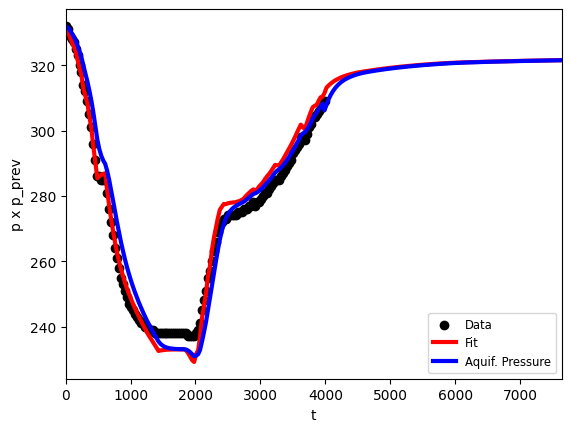

In [72]:
## Gráfico de pressões

plt.scatter(t, p, label="Data", color="black")
plt.plot(t_fc, p_prev_fc, label=f"Fit", color="red", linewidth=3)
plt.plot(t_fc, pa_med_fc, label="Aquif. Pressure", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p x p_prev")
plt.xlim(0, fc_df.iloc[-1, 6])
plt.show()

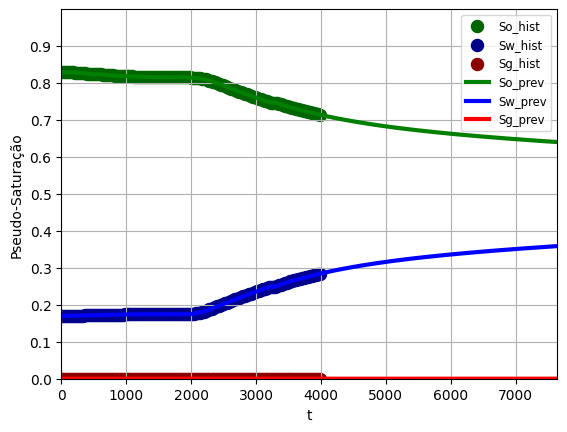

In [73]:
## Gráfico de saturações

fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 1., 0.1))
plt.grid()
plt.scatter(t, So, label="So_hist", color="darkgreen", s=75)
plt.scatter(t, Sw, label="Sw_hist", color="darkblue", s=75)
plt.scatter(t, Sg, label="Sg_hist", color="darkred", s=75)
plt.plot(t_fc, so_fc, label="So_prev", color="green", linewidth=3)
plt.plot(t_fc, sw_fc, label="Sw_prev", color="blue", linewidth=3)
plt.plot(t_fc, sg_fc, label="Sg_prev", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("Pseudo-Saturação")
plt.ylim(0.0, 1.0)
plt.xlim(0, fc_df.iloc[-1, 6])
plt.show()

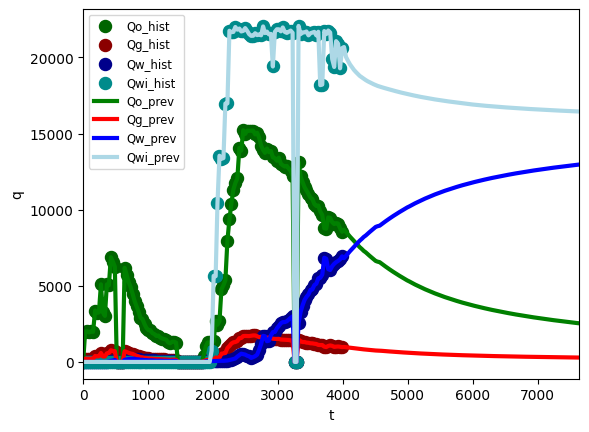

In [74]:
## Gráfico de vazões

plt.scatter(t, qo, label="Qo_hist", color="darkgreen", s=75)
plt.scatter(t, qg/1000, label="Qg_hist", color="darkred", s=75)
plt.scatter(t, qw, label="Qw_hist", color="darkblue", s=75)
plt.scatter(t, qwi, label="Qwi_hist", color="darkcyan", s=75)
plt.plot(t_fc, qo_fc, label=f"Qo_prev", color="green", linewidth=3)
plt.plot(t_fc, qg_fc/1000, label=f"Qg_prev", color="red", linewidth=3)
plt.plot(t_fc, qw_fc, label=f"Qw_prev", color="blue", linewidth=3)
plt.plot(t_fc, qwi_fc, label=f"Qwi_prev", color="lightblue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("q")
plt.xlim(0, fc_df.iloc[-1, 6])
plt.show()

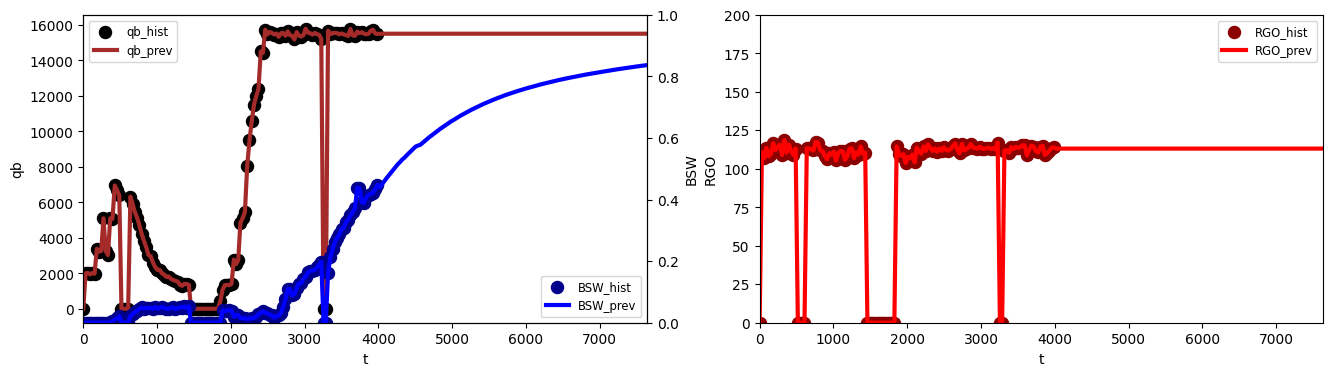

In [76]:
## Gráficos de Qb, BSW e RGO - Campo

qb_hist = np.zeros(len(t))
RGO = np.zeros(len(t))
BSW = np.zeros(len(t))
for i in range(len(t)):
  qb_hist[i]=qo[i]+qw[i]
  if qo[i] == 0:
    RGO[i]=0
  else:
    RGO[i]=qg[i]/qo[i]
  if (qo[i]+qw[i]) == 0:
    BSW[i]=0
  else:
    BSW[i]=qw[i]/(qo[i]+qw[i])

qb_fc = np.zeros(len(t_fc))
RGO_fc = np.zeros(len(t_fc))
BSW_fc = np.zeros(len(t_fc))
for i in range(len(t_fc)):
  qb_fc[i]=qo_fc[i]+qw_fc[i]
  if qo_fc[i] == 0:
    RGO_fc[i]=0
  else:
    RGO_fc[i]=qg_fc[i]/qo_fc[i]
  if (qo_fc[i]+qw_fc[i]) == 0:
    BSW_fc[i]=0
  else:
    BSW_fc[i]=qw_fc[i]/(qo_fc[i]+qw_fc[i])

## Dimensionamento do gráfico
plt.figure(figsize=(16, 4))

# Subplot para Qb e BSW
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(t, qb_hist, label="qb_hist", color="black", s=75)
ax1.plot(t_fc, qb_fc, label="qb_prev", color="brown", linewidth=3)
ax1.set_xlabel("t")
ax1.set_ylabel("qb")
ax1.set_xlim(0, fc_df.iloc[-1, 6])
# ax1.set_ylim(0, 20000)
ax1.legend(loc='upper left', fontsize='small')

# Criar eixos para BSW compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.scatter(t, BSW, label="BSW_hist", color="darkblue", s=75)
ax2.plot(t_fc, BSW_fc, label="BSW_prev", color="blue", linewidth=3)
ax2.set_ylabel("BSW")
ax2.set_ylim(0, 1)
ax2.legend(loc='lower right', fontsize='small')

# Subplot para RGO
ax3 = plt.subplot(1, 2, 2)
ax3.scatter(t, RGO, label="RGO_hist", color="darkred", s=75)
ax3.plot(t_fc, RGO_fc, label="RGO_prev", color="red", linewidth=3)
ax3.set_xlabel("t")
ax3.set_ylabel("RGO")
ax3.set_xlim(0, fc_df.iloc[-1, 6])
ax3.set_ylim(0, 200)
ax3.legend(fontsize='small')

#### Poço

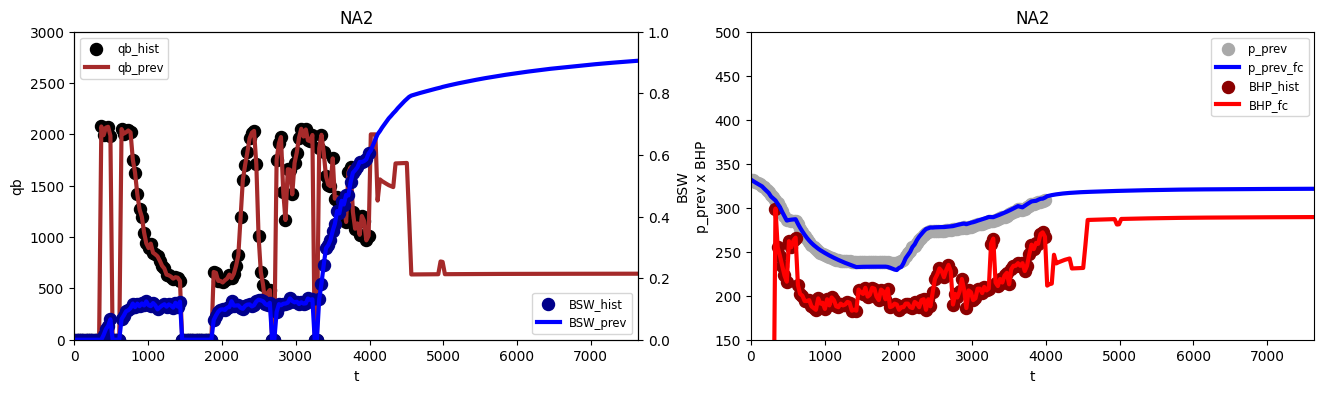

In [77]:
## Gráfico de Qb, BSW e BHP - Poço

w_num = 1
qbw_hist = np.zeros(len(t))
BSWw = np.zeros(len(t))
BHPPw = np.zeros(len(t))
for i in range(len(t)):
  qbw_hist[i]=qow_fc[w_num][i]+qww_fc[w_num][i]
  BHPPw[i]=BHPP_fc[w_num][i]
  if (qow_fc[w_num][i]+qww_fc[w_num][i]) == 0:
    BSWw[i]=0
  else:
    BSWw[i]=qww_fc[w_num][i]/(qow_fc[w_num][i]+qww_fc[w_num][i])

BSWw_fc = np.zeros(len(t_fc))
for i in range(len(t_fc)):
  if (qow_fc[w_num][i]+qww_fc[w_num][i]) == 0:
    BSWw_fc[i]=0
  else:
    BSWw_fc[i]=qww_fc[w_num][i]/(qow_fc[w_num][i]+qww_fc[w_num][i])

## Dimensionamento do gráfico
plt.figure(figsize=(16, 4))

# Criar subplot de Qb
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(t, qbw_hist, label="qb_hist", color="black", s=75)
ax1.plot(t_fc, qbw_fc[w_num], label="qb_prev", color="brown", linewidth=3)
ax1.set_title(wells_prod[w_num])
ax1.set_xlabel("t")
ax1.set_ylabel("qb")
ax1.set_xlim(0, fc_df.iloc[-1, 6])
ax1.set_ylim(0, 3000)
ax1.legend(loc='upper left', fontsize='small')

# Criar eixos para BSW compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.scatter(t, BSWw, label="BSW_hist", color="darkblue", s=75)
ax2.plot(t_fc, BSWw_fc, label="BSW_prev", color="blue", linewidth=3)
ax2.set_ylabel("BSW")
ax2.set_ylim(0, 1)
ax2.legend(loc='lower right', fontsize='small')

# Subplot para BHP
ax3 = plt.subplot(1, 2, 2)
ax3.scatter(t, p, label="p_prev", color="darkgrey", s=75)
ax3.plot(t_fc, p_prev_fc, label="p_prev_fc", color="blue", linewidth=3)
ax3.scatter(t, BHPPw, label="BHP_hist", color="darkred", s=75)
ax3.plot(t_fc,BHPP_fc[w_num], label="BHP_fc", color="red", linewidth=3)
ax3.set_title(wells_prod[w_num])
ax3.set_xlabel("t")
ax3.set_ylabel("p_prev x BHP")
ax3.set_xlim(0, fc_df.iloc[-1, 6])
ax3.set_ylim(150, 500)
ax3.legend(fontsize='small')

plt.show()

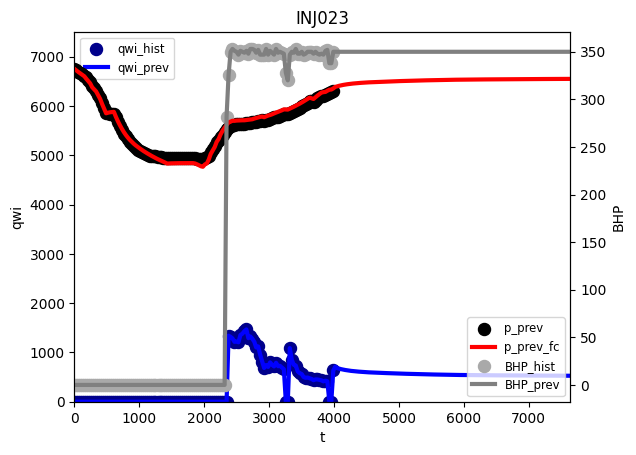

In [78]:
## Gráfico de Qwi - Poço

wi_num = 10

qwiw_hist = np.zeros(len(t))
BHPIw_hist = np.zeros(len(t))
for i in range(len(t)):
  qwiw_hist[i]=qwiw_fc[wi_num][i]
  BHPIw_hist[i]=BHPI_fc[wi_num][i]

# Criar subplot de Qwi
ax1 = plt.subplot(1, 1, 1)
ax1.scatter(t, qwiw_hist, label="qwi_hist", color="darkblue", s=75)
ax1.plot(t_fc, qwiw_fc[wi_num], label="qwi_prev", color="blue", linewidth=3)
ax1.set_title(wells_inj[wi_num])
ax1.set_xlabel("t")
ax1.set_ylabel("qwi")
ax1.set_xlim(0, fc_df.iloc[-1, 6])
ax1.set_ylim(0, 7500)
ax1.legend(loc='upper left', fontsize='small')

# Criar eixos para BHP compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.scatter(t, p, label="p_prev", color="black", s=75)
ax2.plot(t_fc, p_prev_fc, label="p_prev_fc", color="red", linewidth=3)
ax2.scatter(t, BHPIw_hist, label="BHP_hist", color="darkgrey", s=75)
ax2.plot(t_fc, BHPI_fc[wi_num], label="BHP_prev", color="grey", linewidth=3)
ax2.set_ylabel("BHP")
# ax2.set_ylim(0, 1)
ax2.legend(loc='lower right', fontsize='small')

plt.show()

### Exportando Resultados

#### Campo

In [84]:
# Criando Dataframe com os Resultados

# results_field_df = fc_df.copy() # Todos os resultados do campo
results_field_df = fc_df.loc[:, ['Date', 'Np']].iloc[-1:] # Filtrando resultados do campo
results_field_df['tempo_fc'] = tempo_fc # Acrescentando o tempo de execução ao df
results_field_df

,Date,Np,tempo_fc
251,2034-05-31,4.207832e+07,22.857855


In [80]:
# Salvando o DataFrame em um arquivo Excel
results_field_df.to_excel('/content/drive/MyDrive/UNISIM/results_field_0.xlsx', sheet_name='results_field', index=False)

*   Rodada 0: Sem LP
*   Rodada 1: Com LP (freq=1, iter=False)
*   Rodada 2: Com LP (freq=3, iter=False)
*   Rodada 3: Com LP (freq=6, iter=False)
*   Rodada 4: Com LP (freq=1, iter=False, max_iter=100)
*   Rodada 5: Com LP (freq=3, iter=False, max_iter=200)
*   Rodada 6: Com LP (freq=6, iter=False, max_iter=300)
*   Rodada 7: Com LP (freq=1, iter=False, max_iter=100, lim=5)
*   Rodada 8: Com LP (freq=3, iter=False, max_iter=200, lim=10)
*   Rodada 9: Com LP (freq=6, iter=False, max_iter=300, lim=15)